In [1]:
from hmc_base import *
from hmc_unconstrained import *
import autograd.numpy as np
import matplotlib.pyplot as plt
from scipy.special import beta, comb
from scipy.stats import multivariate_normal
import operator as op

# Import data from LearnBayes package

In [14]:
# get data pair list
file = open("cancermortality.txt", "r") 
data = (file.read()) 
tmp = data.split()
tmp = tmp[2:len(tmp)]
tmp = [int(e) for e in tmp]
data_list = []
for i in range(0, int(len(tmp)-1), 2):
    data_list.append([tmp[i], tmp[i+1]])

In [15]:
# get death number list
death = []
for i in range(len(data_list)):
    death.append(data_list[i][0])
# convert to np array
death = np.array(death)

# get risk number list
risk = []
for i in range(len(data_list)):
    risk.append(data_list[i][1])
# convert to np array
risk = np.array(risk)

In [4]:
risk[0]

1083

# Posterior distribution for position x

In [16]:
# define posterior probability function for the beta-binomial distribution 
def posterior(y, n, eta, k):
    t1 = 1/(eta*(1-eta))
    t2 = 1/np.power((1+k), 2)
    t3 = np.prod(beta(k*eta+y, k*(1-eta)+n-y)/beta(k*eta, k*(1-eta)))
    final = t1*t2*t3
    return final
    
def log_posterior(y, n, eta, k):
    t1 = 0-np.log(eta)-np.log(1-eta)
    t2 = 0-2*np.log(1+k)
    t3 = np.log(beta(k*eta+y, k*(1-eta)+n-y))-np.log(beta(k*eta, k*(1-eta)))
    t3 = np.sum(t3)
    final = t1+t2+t3
    return final

# energy function for posterior
def posterior_energy(y, n, eta, k):
    post = posterior(y, n, eta, k)
    return -np.log(post)

In [17]:
log_posterior(death, risk, 0.01, 1000)

-658.08077990418951

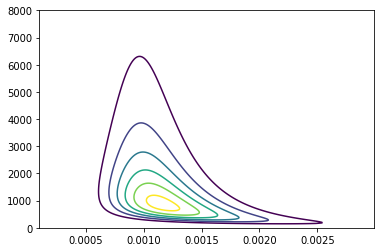

In [18]:
# create grid and contour values
x = np.arange(0.0001, 0.003, 0.00001)
y = np.arange(1, 20000, 20)
X, Y = np.meshgrid(x, y)
xrange = X.shape[1]
yrange = X.shape[0]
Z = np.zeros([yrange, xrange])
for i in range(xrange):
    for j in range(yrange):
        Z[j][i] = posterior(death, risk, X[j][i], Y[j][i])
# plot
plt.figure()
plt.ylim([0, 8000])
CS = plt.contour(X, Y, Z)

# Compute expression of lower bound

In [19]:
# parameters to optimize
mass = 1.
mass_matrix = mass*np.identity(2)
n_steps = 5
z0_mean = np.array([0, 0])
z0_cov = np.identity(2)

In [124]:
eta = 0.4345279       
k = 1008.37605743
y = 0
n = 1083
print(beta(k*eta+y, k*(1-eta)+n-y))
print(beta(k*eta, k*(1-eta)))

0.0
2.60623841713e-301


In [82]:
def prior_beta_binomial(eta, k):
    t1 = 1/(eta*(1-eta))
    t2 = 1/np.power((1+k), 2)
    return t1*t2

def likelihood_beta_binomial(y, n, eta, k):
    n_data = y.shape[0]
    result = 1.
    for i in range(n_data):
        n_comb = comb(n[i], y[i])
        one_likelihood = beta(k*eta+y[i], k*(1-eta)+n[i]-y[i])/beta(k*eta, k*(1-eta))
        one_likelihood = n_comb*one_likelihood
        print(beta(k*eta+y[i], k*(1-eta)+n[i]-y[i]))
        print(beta(k*eta, k*(1-eta)))
        print("===================")
        result = result*one_likelihood
    return result

def joint_beta_binomial(y, n, eta, k):
    prior = prior_beta_binomial(eta, k)
    print("prior"+str(prior))
    likelihood = likelihood_beta_binomial(y, n, eta, k)
    print("like"+str(likelihood))
    return prior*likelihood

# define posterior probability function for the beta-binomial distribution 
def posterior(y, n, eta, k):
    t1 = 1/(eta*(1-eta))
    t2 = 1/np.power((1+k), 2)
    t3 = np.prod(beta(k*eta+y, k*(1-eta)+n-y)/beta(k*eta, k*(1-eta)))
    final = t1*t2*t3
    return final

'''
# energy function for posterior
def posterior_energy(y, n, theta):
    eta = theta[0]
    k = theta[1]
    post = posterior(y, n, eta, k)
    return -np.log(post)
'''

'\n# energy function for posterior\ndef posterior_energy(y, n, theta):\n    eta = theta[0]\n    k = theta[1]\n    post = posterior(y, n, eta, k)\n    return -np.log(post)\n'

In [135]:
def lower_bound(y, n, mass_matrix, n_steps, z0_mean, z0_cov, v1_p_mean, v1_p_cov, v1_mean, v1_cov, joint_function):
    # sample epsilson
    eps_mean1 = np.array([0, 0])
    eps_cov1 = np.identity(2)
    eps1 = np.random.multivariate_normal(eps_mean1, eps_cov1)
    
    eps_mean2 = np.array([0, 0])
    eps_cov2 = np.identity(2)
    eps2 = np.random.multivariate_normal(eps_mean2, eps_cov2)
    
    eps_mean3 = np.array([0, 0])
    eps_cov3 = np.identity(2)
    eps3 = np.random.multivariate_normal(eps_mean3, eps_cov3)
    
    # Draw an initial random variable z0
    z0 = z0_mean + np.sqrt(z0_cov).dot(eps1)
    print(z0)
    eta0 = (np.tanh(z0[0])+1)/200 #range(0, 0.01)
    k0 = np.absolute(z0[1])
    print(eta0, k0)
    # Init. lower bound
    joint_t0 = joint_function(y, n, eta0, k0)
    L1 = np.log(joint_t0)
    L2 = np.log(multivariate_normal.pdf(z0, z0_mean, z0_cov))
    L = L1 - L2
    
    # define energy function
    def posterior_energy(theta, cache):
        eta = theta[0]
        k = theta[1]
        post = posterior(y, n, eta, k)
        return -np.log(post)
    
    # MCMC steps
    for i in range(1):
        # Draw vt'
        vt_p = v1_p_mean + np.sqrt(v1_p_cov).dot(eps2)
        
        #init hmc sampler
        sampler = IsotropicHmcSampler(posterior_energy, energy_grad=None, prng=None,
                 mom_resample_coeff=0., dtype=np.float64)
        pos_samples, mom_samples, ratio = sampler.get_samples(np.array([eta0, k0]), 0.1, n_steps, 1, mass_matrix)
        z1 = pos_samples[0]
        v1 = mom_samples[0]
        #eta1 = z1[0]
        #k1 = z1[1]
        eta1 = (np.tanh(z1[0])+1)/200 #range(0, 0.01)
        k1 = np.absolute(z1[1])
        
        joint_t1 = joint_function(y, n, eta1, k1) 
        rt = multivariate_normal.pdf(v1, v1_mean, v1_cov)
        qt = multivariate_normal.pdf(vt_p, v1_p_mean, v1_p_cov)
        
        alpha = (joint_t1*rt)/(joint_t0*qt)
        L = L + np.log(alpha)
    
    
    
    return pos_samples, L

In [145]:
z0_mean = np.array([0.001,1000]) 
z0_cov = np.array([[1,0],[0,10]])
v1_p_mean = np.array([0,0])
v1_p_cov = np.identity(2)
v1_mean = np.array([0,0])
v1_cov = np.identity(2)

In [146]:
sample_list = []
for i in range(1000):
    pos_samples, L = lower_bound(death, risk, mass_matrix, 5, z0_mean, z0_cov, v1_p_mean, v1_p_cov, v1_mean, v1_cov, joint_beta_binomial)
    sample_list.append(pos_samples)

[    1.81507832  1000.08652021]
0.0097417270297 1000.08652021
prior0.000103436147636
9.72150213817e-28
1.27136487347e-24
3.01682777823e-27
1.27136487347e-24
3.0395072699e-36
1.27136487347e-24
9.09056709395e-27
1.27136487347e-24
2.43958935485e-30
1.27136487347e-24
6.1953664375e-30
1.27136487347e-24
2.02043528941e-26
1.27136487347e-24
1.28567059747e-33
1.27136487347e-24
8.80356432297e-29
1.27136487347e-24
4.53707472458e-33
1.27136487347e-24
2.18802813626e-27
1.27136487347e-24
1.57521191115e-29
1.27136487347e-24
4.63667462674e-29
1.27136487347e-24
1.11821463416e-29
1.27136487347e-24
7.41570306086e-216
1.27136487347e-24
2.73092915312e-27
1.27136487347e-24
4.8907715133e-26
1.27136487347e-24
8.92438637359e-29
1.27136487347e-24
4.32251721962e-33
1.27136487347e-24
5.32195902467e-26
1.27136487347e-24
like8.09416520933e-49
prior0.000198643691225
4.56066095677e-16
1.86850587296e-14
8.19614433182e-16
1.86850587296e-14
1.4952528018e-23
1.86850587296e-14
1.45057972755e-15
1.86850587296e-14
7.7884786

1.70324593478e-18
2.37432232165e-14
2.83038990727e-15
2.37432232165e-14
7.31511688406e-22
2.37432232165e-14
7.50572662657e-18
2.37432232165e-14
1.28129603211e-22
2.37432232165e-14
9.03701473043e-16
2.37432232165e-14
2.86924879377e-18
2.37432232165e-14
5.24552862173e-18
2.37432232165e-14
2.36920637869e-18
2.37432232165e-14
7.17726026004e-202
2.37432232165e-14
1.0126627229e-15
2.37432232165e-14
4.45672774101e-15
2.37432232165e-14
7.56311640239e-18
2.37432232165e-14
1.24290354587e-22
2.37432232165e-14
4.65436003766e-15
2.37432232165e-14
like2.44061780013e-25
[ -8.47293461e-01   1.00109359e+03]
0.00155173567299 1001.09359328
prior0.000642747088799
6.2181528122e-06
1.94441058789e-05
7.44520744545e-06
1.94441058789e-05
3.79994171829e-13
1.94441058789e-05
8.87229996359e-06
1.94441058789e-05
3.99872514474e-09
1.94441058789e-05
4.98764302643e-09
1.94441058789e-05
1.00731140199e-05
1.94441058789e-05
2.36234431234e-12
1.94441058789e-05
9.35566116165e-09
1.94441058789e-05
3.41005768111e-14
1.94441

2.33181677218e-22
9.49464627945e-31
2.33181677218e-22
1.38799076226e-23
2.33181677218e-22
like4.0883070046e-43
prior0.000199880304284
5.13481983776e-16
2.08960513664e-14
9.21539644391e-16
2.08960513664e-14
1.69217836778e-23
2.08960513664e-14
1.6289502587e-15
2.08960513664e-14
8.75357616287e-19
2.08960513664e-14
1.47717650719e-18
2.08960513664e-14
2.46058261582e-15
2.08960513664e-14
6.32475794923e-22
2.08960513664e-14
6.5549044867e-18
2.08960513664e-14
1.12904666824e-22
2.08960513664e-14
7.8067996135e-16
2.08960513664e-14
2.49444684551e-18
2.08960513664e-14
4.57325067379e-18
2.08960513664e-14
2.05788824701e-18
2.08960513664e-14
6.07053576409e-202
2.08960513664e-14
8.75353442556e-16
2.08960513664e-14
3.88435882583e-15
2.08960513664e-14
6.60526371943e-18
2.08960513664e-14
1.09509171762e-22
2.08960513664e-14
4.05760835593e-15
2.08960513664e-14
like1.82673780949e-25
[   1.16803015  998.39975549]
0.00911819829218 998.399755487
prior0.000110812980842
3.18214574335e-26
2.61633901754e-23
9.1749

8.895182721e-05
3.7310995197e-05
8.895182721e-05
2.79993104413e-08
8.895182721e-05
3.53811860758e-08
8.895182721e-05
2.59948625737e-08
8.895182721e-05
6.48213491446e-191
8.895182721e-05
3.84580997925e-05
8.895182721e-05
5.70317786285e-05
8.895182721e-05
4.07752081802e-08
8.895182721e-05
1.25116320738e-13
8.895182721e-05
5.76933861014e-05
8.895182721e-05
like1.17122360606e-13
prior0.000200272915953
5.8857936218e-16
2.3380665675e-14
1.05262512598e-15
2.3380665675e-14
1.96207788685e-23
2.3380665675e-14
1.85415638389e-15
2.3380665675e-14
9.99240279921e-19
2.3380665675e-14
1.68171657434e-18
2.3380665675e-14
2.79349163959e-15
2.3380665675e-14
7.22561605801e-22
2.3380665675e-14
7.40325127683e-18
2.3380665675e-14
1.26170659444e-22
2.3380665675e-14
8.92622808035e-16
2.3380665675e-14
2.83206534198e-18
2.3380665675e-14
5.17535631715e-18
2.3380665675e-14
2.33879109163e-18
2.3380665675e-14
7.09955042972e-202
2.3380665675e-14
1.00018058924e-15
2.3380665675e-14
4.39692571254e-15
2.3380665675e-14
7.45

3.74384851566
4.00699398193
2.08850423847e-08
4.00699398193
3.79063169915
4.00699398193
0.000183145914764
4.00699398193
0.000201575919345
4.00699398193
3.82485059184
4.00699398193
6.17279591285e-08
4.00699398193
0.000264800807059
4.00699398193
2.47345503078e-10
4.00699398193
3.73032873444
4.00699398193
0.000221879116911
4.00699398193
0.000247919485311
4.00699398193
0.000214197633133
4.00699398193
3.05147840763e-187
4.00699398193
3.73965280153
4.00699398193
3.86306668997
4.00699398193
0.000265171842544
4.00699398193
2.44455595673e-10
4.00699398193
3.86673787359
4.00699398193
like5.6926494747e-22
prior0.000198608976709
5.21457519766e-16
2.07271358021e-14
9.33193125972e-16
2.07271358021e-14
1.73298785267e-23
2.07271358021e-14
1.64455317623e-15
2.07271358021e-14
8.86176964985e-19
2.07271358021e-14
1.491978047e-18
2.07271358021e-14
2.47825976109e-15
2.07271358021e-14
6.4083256108e-22
2.07271358021e-14
6.5707802634e-18
2.07271358021e-14
1.11922153183e-22
2.07271358021e-14
7.91211473519e-16
2

8.89521166064e-16
2.11554780753e-14
3.94089745142e-15
2.11554780753e-14
6.69884688858e-18
2.11554780753e-14
1.10852317556e-22
2.11554780753e-14
4.11646143656e-15
2.11554780753e-14
like1.93965827728e-25
[  3.08665495e-01   9.97544780e+02]
0.00649611280761 997.544779687
prior0.000155396695821
8.84144039005e-20
1.04904029881e-17
1.87845811481e-19
1.04904029881e-17
1.53974535397e-27
1.04904029881e-17
3.91377374376e-19
1.04904029881e-17
1.78476701401e-22
1.04904029881e-17
3.41613349039e-22
1.04904029881e-17
6.65938365317e-19
1.04904029881e-17
1.21511263103e-25
1.04904029881e-17
2.17023029108e-21
1.04904029881e-17
5.60752352789e-26
1.04904029881e-17
1.5169503695e-19
1.04904029881e-17
6.54429058614e-22
1.04904029881e-17
1.38838044883e-21
1.04904029881e-17
5.15456383059e-22
1.04904029881e-17
3.06838077903e-206
1.04904029881e-17
1.75803206631e-19
1.04904029881e-17
1.19939433578e-18
1.04904029881e-17
2.19093871422e-21
1.04904029881e-17
5.40890621381e-26
1.04904029881e-17
1.26877531758e-18
1.0490

1.8967541045e-14
5.76365884558e-22
1.8967541045e-14
5.96617171687e-18
1.8967541045e-14
1.0252709138e-22
1.8967541045e-14
7.11141386368e-16
1.8967541045e-14
2.27204929181e-18
1.8967541045e-14
4.16384588116e-18
1.8967541045e-14
1.87458494783e-18
1.8967541045e-14
5.51467691137e-202
1.8967541045e-14
7.97379290981e-16
1.8967541045e-14
3.53572328979e-15
1.8967541045e-14
6.01196225559e-18
1.8967541045e-14
9.94483480295e-23
1.8967541045e-14
3.69326200806e-15
1.8967541045e-14
like1.93415305455e-25
[   1.22726304  997.43813785]
0.00920891804763 997.438137847
prior0.000109942847212
2.0423434785e-26
1.7921352713e-23
5.94808218104e-26
1.7921352713e-23
8.69155039828e-35
1.7921352713e-23
1.68512138062e-25
1.7921352713e-23
4.99375055989e-29
1.7921352713e-23
1.20952126425e-28
1.7921352713e-23
3.58208416517e-25
1.7921352713e-23
2.7703406504e-32
1.7921352713e-23
1.50270494657e-27
1.7921352713e-23
7.01054650052e-32
1.7921352713e-23
4.39230243977e-26
1.7921352713e-23
2.93315243983e-28
1.7921352713e-23
8.17

0.00445134702031
0.00572797288717
like3.85002417039e-14
prior0.000202438455184
7.08638493017e-16
2.7938669068e-14
1.26508528209e-15
2.7938669068e-14
2.37878043848e-23
2.7938669068e-14
2.22492954356e-15
2.7938669068e-14
1.20018270091e-18
2.7938669068e-14
2.01747979831e-18
2.7938669068e-14
3.34873319153e-15
2.7938669068e-14
8.6800626545e-22
2.7938669068e-14
8.85687884793e-18
2.7938669068e-14
1.50594319327e-22
2.7938669068e-14
1.07331130061e-15
2.7938669068e-14
3.39380875018e-18
2.7938669068e-14
6.19506051451e-18
2.7938669068e-14
2.80377352571e-18
2.7938669068e-14
8.6612994709e-202
2.7938669068e-14
1.20223513467e-15
2.7938669068e-14
5.2656964263e-15
2.7938669068e-14
8.92444323966e-18
2.7938669068e-14
1.46087194528e-22
2.7938669068e-14
5.49851133746e-15
2.7938669068e-14
like2.8149667091e-25
[  6.28406747e-01   1.00684867e+03]
0.00778477080793 1006.84867176
prior0.000127455219379
3.51009502345e-23
1.09382300501e-20
8.69847681089e-23
1.09382300501e-20
3.14216479246e-31
1.09382300501e-20
2.10

2.97417474589e-28
1.78212873258e-23
8.26284163941e-28
1.78212873258e-23
2.15035894354e-28
1.78212873258e-23
3.36759014389e-214
1.78212873258e-23
5.50854378066e-26
1.78212873258e-23
8.32032666861e-25
1.78212873258e-23
1.53550394231e-27
1.78212873258e-23
6.70661806265e-32
1.78212873258e-23
9.00870055768e-25
1.78212873258e-23
like9.12431206875e-46
prior0.000198124790287
4.40178540485e-16
1.80268028575e-14
7.91159322536e-16
1.80268028575e-14
1.44214121693e-23
1.80268028575e-14
1.40030748726e-15
1.80268028575e-14
7.51879214949e-19
1.80268028575e-14
1.27008133996e-18
1.80268028575e-14
2.11699354447e-15
1.80268028575e-14
5.43173918103e-22
1.80268028575e-14
5.64902668812e-18
1.80268028575e-14
9.74927324511e-23
1.80268028575e-14
6.69955677525e-16
1.80268028575e-14
2.14669252133e-18
1.80268028575e-14
3.93934119314e-18
1.80268028575e-14
1.77042184656e-18
1.80268028575e-14
5.14601612702e-202
1.80268028575e-14
7.51413691657e-16
1.80268028575e-14
3.34471503368e-15
1.80268028575e-14
5.69248106985e-18

3.29399009757e-15
5.45121667344e-16
3.29399009757e-15
9.48732243717e-19
3.29399009757e-15
1.74343072586e-23
3.29399009757e-15
5.71152812354e-16
3.29399009757e-15
like5.09561453999e-27
prior0.000200629661049
5.72328548549e-16
2.30052918861e-14
1.02512436459e-15
2.30052918861e-14
1.89897111942e-23
2.30052918861e-14
1.80858396531e-15
2.30052918861e-14
9.73333071238e-19
2.30052918861e-14
1.64010224567e-18
2.30052918861e-14
2.72815569043e-15
2.30052918861e-14
7.0354070998e-22
2.30052918861e-14
7.24775294703e-18
2.30052918861e-14
1.24198000631e-22
2.30052918861e-14
8.68917327711e-16
2.30052918861e-14
2.76552059142e-18
2.30052918861e-14
5.06168616992e-18
2.30052918861e-14
2.28274624002e-18
2.30052918861e-14
6.84920992395e-202
2.30052918861e-14
9.73915400953e-16
2.30052918861e-14
4.30020850105e-15
2.30052918861e-14
7.30328049442e-18
2.30052918861e-14
1.2047037076e-22
2.30052918861e-14
4.49135392669e-15
2.30052918861e-14
like2.16482412864e-25
[ -1.06193046e-01   9.93881557e+02]
0.0044710216985 

4.21820804596e-15
2.25649478843e-14
7.16446026594e-18
2.25649478843e-14
1.18177441836e-22
2.25649478843e-14
4.40571853955e-15
2.25649478843e-14
like2.16098551215e-25
[    1.00759531  1000.00903172]
0.00882382793318 1000.00903172
prior0.000114108008124
1.4717556509e-25
9.76639494979e-23
4.10384238223e-25
9.76639494979e-23
7.68534030763e-34
9.76639494979e-23
1.11420641295e-24
9.76639494979e-23
3.52849038907e-28
9.76639494979e-23
8.27293087574e-28
9.76639494979e-23
2.29634776463e-24
9.76639494979e-23
2.02418949389e-31
9.76639494979e-23
9.36395397238e-27
9.76639494979e-23
4.06120279637e-31
9.76639494979e-23
3.06812108056e-25
9.76639494979e-23
1.94178328767e-27
9.76639494979e-23
5.21050051832e-27
9.76639494979e-23
1.41951699722e-27
9.76639494979e-23
3.71761310745e-213
9.76639494979e-23
3.75004008418e-25
9.76639494979e-23
5.11300431239e-24
9.76639494979e-23
9.4813796871e-27
9.76639494979e-23
3.882728403e-31
9.76639494979e-23
5.51951722934e-24
9.76639494979e-23
like5.83115589318e-44
prior0.00

7.36416762665e-18
2.32854990837e-14
1.25670531844e-22
2.32854990837e-14
8.86689240837e-16
2.32854990837e-14
2.81537939676e-18
2.32854990837e-14
5.14681504469e-18
2.32854990837e-14
2.32474295928e-18
2.32854990837e-14
7.03701581738e-202
2.32854990837e-14
9.93605330085e-16
2.32854990837e-14
4.37263644076e-15
2.32854990837e-14
7.42046735019e-18
2.32854990837e-14
1.2190588913e-22
2.32854990837e-14
4.56651457522e-15
2.32854990837e-14
like2.45919671671e-25
[  -1.28557987  996.34840203]
0.000710177526757 996.34840203
prior0.00141660189451
0.00577727505183
0.00972623572358
0.0062723243464
0.00972623572358
2.05010967498e-10
0.00972623572358
0.00679523838895
0.00972623572358
1.78078296519e-06
0.00972623572358
2.06501933674e-06
0.00972623572358
0.00720084691335
0.00972623572358
8.26442067027e-10
0.00972623572358
3.14813598568e-06
0.00972623572358
5.8728509915e-12
0.00972623572358
0.00612775344191
0.00972623572358
2.39506865932e-06
0.00972623572358
2.84324027213e-06
0.00972623572358
2.26815714852e-

prior0.000201058331616
5.88839825281e-16
2.36782079847e-14
1.05460188181e-15
2.36782079847e-14
1.95481811977e-23
2.36782079847e-14
1.86050949225e-15
2.36782079847e-14
1.00124431004e-18
2.36782079847e-14
1.68707453905e-18
2.36782079847e-14
2.8064830318e-15
2.36782079847e-14
7.23694338526e-22
2.36782079847e-14
7.45584771361e-18
2.36782079847e-14
1.27812965402e-22
2.36782079847e-14
8.93922191067e-16
2.36782079847e-14
2.84470830018e-18
2.36782079847e-14
5.2067965178e-18
2.36782079847e-14
2.34810679864e-18
2.36782079847e-14
7.0551670577e-202
2.36782079847e-14
1.00192662684e-15
2.36782079847e-14
4.42382104412e-15
2.36782079847e-14
7.51297768157e-18
2.36782079847e-14
1.2397565785e-22
2.36782079847e-14
4.62048523714e-15
2.36782079847e-14
like2.14817108062e-25
[  3.84088098e-01   9.98047827e+02]
0.00683126236493 998.047826839
prior0.000147673794766
1.2363048814e-20
1.87928415804e-18
2.73151745125e-20
1.87928415804e-18
1.83051950336e-28
1.87928415804e-18
5.91221790067e-20
1.87928415804e-18
2.574

2.75679723176e-06
7.98800821684e-10
2.75679723176e-06
1.90682696886e-192
2.75679723176e-06
8.6410936848e-07
2.75679723176e-06
1.49046131472e-06
2.75679723176e-06
1.38297087497e-09
2.75679723176e-06
5.95712301464e-15
2.75679723176e-06
1.51443595372e-06
2.75679723176e-06
like2.7421538947e-14
prior0.000200211104095
5.81341707573e-16
2.31342128277e-14
1.03996058613e-15
2.31342128277e-14
1.93620948066e-23
2.31342128277e-14
1.83233420476e-15
2.31342128277e-14
9.8727180286e-19
2.31342128277e-14
1.66191123724e-18
2.31342128277e-14
2.76115086433e-15
2.31342128277e-14
7.1386664057e-22
2.31342128277e-14
7.32039186895e-18
2.31342128277e-14
1.24854214341e-22
2.31342128277e-14
8.81815799069e-16
2.31342128277e-14
2.79928805889e-18
2.31342128277e-14
5.11669134818e-18
2.31342128277e-14
2.31154761483e-18
2.31342128277e-14
7.00112683116e-202
2.31342128277e-14
9.88123548166e-16
2.31342128277e-14
4.34696817845e-15
2.31342128277e-14
7.37634185007e-18
2.31342128277e-14
1.21115112195e-22
2.31342128277e-14
4.5

1.02617254324e-30
5.92411971126e-25
2.64037842406e-30
5.92411971126e-25
8.84718348431e-27
5.92411971126e-25
5.32894403275e-34
5.92411971126e-25
3.89317213763e-29
5.92411971126e-25
2.05997122479e-33
5.92411971126e-25
9.25853508829e-28
5.92411971126e-25
6.80159985334e-30
5.92411971126e-25
2.03236107344e-29
5.92411971126e-25
4.80527055077e-30
5.92411971126e-25
2.51073693327e-216
5.92411971126e-25
1.15955731937e-27
5.92411971126e-25
2.17062736155e-26
5.92411971126e-25
3.94734516855e-29
5.92411971126e-25
1.96146587697e-33
5.92411971126e-25
2.36502715627e-26
5.92411971126e-25
like1.3088767717e-49
prior0.00019791327852
4.27988680295e-16
1.75776378079e-14
7.69612229986e-16
1.75776378079e-14
1.39989014057e-23
1.75776378079e-14
1.36278686941e-15
1.75776378079e-14
7.31477883279e-19
1.75776378079e-14
1.23604828299e-18
1.75776378079e-14
2.06093583635e-15
1.75776378079e-14
5.28387242574e-22
1.75776378079e-14
5.50296515569e-18
1.75776378079e-14
9.50828221266e-23
1.75776378079e-14
6.51622887086e-16
1.

1.03924557854e-22
1.98258776883e-14
3.85788221965e-15
1.98258776883e-14
like1.91634753104e-25
[   1.00303501  994.95701058]
0.00881432919037 994.957010577
prior0.000115391689721
2.02602390532e-25
1.32228621102e-22
5.62873115475e-25
1.32228621102e-22
1.07984429017e-33
1.32228621102e-22
1.52325580815e-24
1.32228621102e-22
4.84803582738e-28
1.32228621102e-22
1.1336531589e-27
1.32228621102e-22
3.1326677893e-24
1.32228621102e-22
2.78884997885e-31
1.32228621102e-22
1.27482529134e-26
1.32228621102e-22
5.50604459845e-31
1.32228621102e-22
4.21239850565e-25
1.32228621102e-22
2.65426359811e-27
1.32228621102e-22
7.10371774088e-27
1.32228621102e-22
1.94209197294e-27
1.32228621102e-22
5.39221823121e-213
1.32228621102e-22
5.14505529574e-25
1.32228621102e-22
6.9602104956e-24
1.32228621102e-22
1.29077451795e-26
1.32228621102e-22
5.26440392247e-31
1.32228621102e-22
7.51214902132e-24
1.32228621102e-22
like7.68215565412e-44
prior0.000200878668527
5.56639276494e-16
2.26016316961e-14
9.9834058681e-16
2.2601

2.33708389702e-14
8.94521919347e-16
2.33708389702e-14
2.8360857305e-18
2.33708389702e-14
5.18079838828e-18
2.33708389702e-14
2.34237043674e-18
2.33708389702e-14
7.12815223749e-202
2.33708389702e-14
1.00224010378e-15
2.33708389702e-14
4.40154137684e-15
2.33708389702e-14
7.46587951108e-18
2.33708389702e-14
1.2233402165e-22
2.33708389702e-14
4.59639243495e-15
2.33708389702e-14
like2.66528651871e-25
[   -1.53988265  1006.18005343]
0.000439496761494 1006.18005343
prior0.002243990434
0.068173835713
0.0941896821881
0.0717495866143
0.0941896821881
1.55811060647e-09
0.0941896821881
0.0754101796226
0.0941896821881
1.32786906061e-05
0.0941896821881
1.50389734426e-05
0.0941896821881
0.0781749373987
0.0941896821881
5.45886077679e-09
0.0941896821881
2.14302527429e-05
0.0941896821881
3.00639415211e-11
0.0941896821881
0.0707169670416
0.0941896821881
1.70343637084e-05
0.0941896821881
1.9673889742e-05
0.0941896821881
1.62727468046e-05
0.0941896821881
3.0625005325e-188
0.0941896821881
0.0714279239013
0.0

1.77741026593e-14
1.42521515994e-23
1.77741026593e-14
1.38283470707e-15
1.77741026593e-14
7.42662351335e-19
1.77741026593e-14
1.25431622542e-18
1.77741026593e-14
2.09020741135e-15
1.77741026593e-14
5.36556795602e-22
1.77741026593e-14
5.57558610874e-18
1.77741026593e-14
9.61284586703e-23
1.77741026593e-14
6.61767219014e-16
1.77741026593e-14
2.1196594994e-18
1.77741026593e-14
3.88877378703e-18
1.77741026593e-14
1.74824984176e-18
1.77741026593e-14
5.08611963778e-202
1.77741026593e-14
7.42203110935e-16
1.77741026593e-14
3.30164731483e-15
1.77741026593e-14
5.61845476435e-18
1.77741026593e-14
9.32382133682e-23
1.77741026593e-14
3.44907630351e-15
1.77741026593e-14
like1.73531620432e-25
[ -2.29942268e-01   1.00201426e+03]
0.00387013215607 1002.01426067
prior0.000257836280133
6.96937351594e-13
1.200661046e-11
1.09262632754e-12
1.200661046e-11
3.45970480179e-20
1.200661046e-11
1.69285313449e-12
1.200661046e-11
9.77662497297e-16
1.200661046e-11
1.49125770541e-15
1.200661046e-11
2.32411941351e-12


1.31437874062e-210
6.44822729677e-21
4.25964654502e-23
6.44822729677e-21
4.5003557957e-22
6.44822729677e-21
8.38838185679e-25
6.44822729677e-21
2.8944150274e-29
6.44822729677e-21
4.82203613555e-22
6.44822729677e-21
like1.59937818187e-39
prior0.000199486842656
5.01871072338e-16
2.04003405132e-14
9.00680608525e-16
2.04003405132e-14
1.65365371827e-23
2.04003405132e-14
1.59196804205e-15
2.04003405132e-14
8.55589414805e-19
2.04003405132e-14
1.44374347016e-18
2.04003405132e-14
2.40452140047e-15
2.04003405132e-14
6.18225274289e-22
2.04003405132e-14
6.40450520224e-18
2.04003405132e-14
1.10236950882e-22
2.04003405132e-14
7.63017946119e-16
2.04003405132e-14
2.43779188358e-18
2.04003405132e-14
4.46877824838e-18
2.04003405132e-14
2.01121589477e-18
2.04003405132e-14
5.93026987798e-202
2.04003405132e-14
8.55543195787e-16
2.04003405132e-14
3.79538115209e-15
2.04003405132e-14
6.45369363862e-18
2.04003405132e-14
1.06923126611e-22
2.04003405132e-14
3.96460645096e-15
2.04003405132e-14
like1.86004218427e-

6.20736381211e-19
9.78518827707e-18
1.13137337226e-25
9.78518827707e-18
2.02384706135e-21
9.78518827707e-18
5.23210026475e-26
9.78518827707e-18
1.41257433025e-19
9.78518827707e-18
6.09962221032e-22
9.78518827707e-18
1.29450741593e-21
9.78518827707e-18
4.80370106391e-22
9.78518827707e-18
2.83535988448e-206
9.78518827707e-18
1.63725654821e-19
9.78518827707e-18
1.11830654163e-18
9.78518827707e-18
2.04316560463e-21
9.78518827707e-18
5.04677315734e-26
9.78518827707e-18
1.18302538221e-18
9.78518827707e-18
like3.29883690929e-32
prior0.000199567707776
5.15916428911e-16
2.0869694607e-14
9.25234911292e-16
2.0869694607e-14
1.70387927156e-23
2.0869694607e-14
1.63421598539e-15
2.0869694607e-14
8.78804458326e-19
2.0869694607e-14
1.48211762545e-18
2.0869694607e-14
2.46704252356e-15
2.0869694607e-14
6.35102876089e-22
2.0869694607e-14
6.56419700823e-18
2.0869694607e-14
1.12745360617e-22
2.0869694607e-14
7.83977415936e-16
2.0869694607e-14
2.50120690986e-18
2.0869694607e-14
4.58202572893e-18
2.0869694607

4.18238785572e-15
2.15270696588e-14
like1.86550613697e-25
[  8.53038759e-01   1.00101934e+03]
0.00846326827815 1001.01933538
prior0.0001186863792
1.02994006833e-24
5.24628378952e-22
2.75512691552e-24
5.24628378952e-22
6.52505527585e-33
5.24628378952e-22
7.18338866801e-24
5.24628378952e-22
2.41916036133e-27
5.24628378952e-22
5.49887664427e-27
5.24628378952e-22
1.43762807612e-23
5.24628378952e-22
1.43098472236e-30
5.24628378952e-22
5.69688088513e-26
5.24628378952e-22
2.30024680655e-30
5.24628378952e-22
2.08419867132e-24
5.24628378952e-22
1.2511773117e-26
5.24628378952e-22
3.23860941738e-26
5.24628378952e-22
9.25159748209e-27
5.24628378952e-22
4.03580228021e-212
5.24628378952e-22
2.52681136733e-24
5.24628378952e-22
3.09845026698e-23
5.24628378952e-22
5.7656934587e-26
5.24628378952e-22
2.20217619226e-30
5.24628378952e-22
3.33439229726e-23
5.24628378952e-22
like4.26401745955e-42
prior0.000198524076204
4.59764154155e-16
1.87669829212e-14
8.2586811156e-16
1.87669829212e-14
1.50958294837e-23
1

3.07746464849e-18
2.53831204621e-14
5.62138117146e-18
2.53831204621e-14
2.54184025145e-18
2.53831204621e-14
7.77440412533e-202
2.53831204621e-14
1.08822965035e-15
2.53831204621e-14
4.77688081185e-15
2.53831204621e-14
8.10095526704e-18
2.53831204621e-14
1.32808040587e-22
2.53831204621e-14
4.98835025239e-15
2.53831204621e-14
like2.65272969879e-25
[  2.47371226e-01   1.00521173e+03]
0.00621222994564 1005.211733
prior0.000159985298195
3.44167681045e-19
3.34675506755e-17
7.09419517212e-19
3.34675506755e-17
6.75555409494e-27
3.34675506755e-17
1.43464818513e-18
3.34675506755e-17
6.77241159001e-22
3.34675506755e-17
1.26710478461e-21
3.34675506755e-17
2.38838731488e-18
3.34675506755e-17
4.67651873964e-25
3.34675506755e-17
7.53545098901e-21
3.34675506755e-17
1.81472051868e-25
3.34675506755e-17
5.77851722012e-19
3.34675506755e-17
2.37220421131e-21
3.34675506755e-17
4.89911384934e-21
3.34675506755e-17
1.88434387644e-21
3.34675506755e-17
1.5151065447e-205
3.34675506755e-17
6.65717637686e-19
3.34675

1.30955052333e-15
1.68960374421e-14
7.02821375459e-19
1.68960374421e-14
1.18784176385e-18
1.68960374421e-14
1.9806986328e-15
1.68960374421e-14
5.07681317757e-22
1.68960374421e-14
5.29015592827e-18
1.68960374421e-14
9.14166139395e-23
1.68960374421e-14
6.25971699222e-16
1.68960374421e-14
2.0086866332e-18
1.68960374421e-14
3.68802851946e-18
1.68960374421e-14
1.65631105632e-18
1.68960374421e-14
4.77927839682e-202
1.68960374421e-14
7.02184266119e-16
1.68960374421e-14
3.13084741756e-15
1.68960374421e-14
5.33088095272e-18
1.68960374421e-14
8.86656623542e-23
1.68960374421e-14
3.27086522268e-15
1.68960374421e-14
like1.60679465664e-25
[  2.60852754e-01   9.97519879e+02]
0.00627546484586 997.519878934
prior0.000160832812069
3.21882208667e-19
3.24593136936e-17
6.66557169129e-19
3.24593136936e-17
6.21795733139e-27
3.24593136936e-17
1.35450511113e-18
3.24593136936e-17
6.35763635147e-22
3.24593136936e-17
1.19381063531e-21
3.24593136936e-17
2.26339678034e-18
3.24593136936e-17
4.38018362388e-25
3.24593

0.0232481893863
0.0190245546784
0.0232481893863
6.72341003003e-06
0.0232481893863
1.10774564915e-11
0.0232481893863
0.0191237929565
0.0232481893863
like8.6272054125e-15
prior0.00020050200395
6.06096547532e-16
2.40063278579e-14
1.08342768553e-15
2.40063278579e-14
2.02388833662e-23
2.40063278579e-14
1.90752659865e-15
2.40063278579e-14
1.02836159964e-18
2.40063278579e-14
1.73011039117e-18
2.40063278579e-14
2.87294654763e-15
2.40063278579e-14
7.43684812134e-22
2.40063278579e-14
7.608762061e-18
2.40063278579e-14
1.29517815125e-22
2.40063278579e-14
9.18868974962e-16
2.40063278579e-14
2.91253520928e-18
2.40063278579e-14
5.32027161427e-18
2.40063278579e-14
2.40555514129e-18
2.40063278579e-14
7.33314827257e-202
2.40063278579e-14
1.02949207234e-15
2.40063278579e-14
4.52035086827e-15
2.40063278579e-14
7.66685428946e-18
2.40063278579e-14
1.25642018722e-22
2.40063278579e-14
4.72045653671e-15
2.40063278579e-14
like2.66510523791e-25
[ -1.12039962e-01   1.00082228e+03]
0.00444213253301 1000.82228407
p

1.9872384104e-27
2.84977498569e-19
4.70834820898e-23
2.84977498569e-19
1.4461964672e-27
2.84977498569e-19
2.58395076594e-21
2.84977498569e-19
1.26629346436e-23
2.84977498569e-19
2.88639183664e-23
2.84977498569e-19
9.7492179793e-24
2.84977498569e-19
2.38459361609e-208
2.84977498569e-19
3.04365726935e-21
2.84977498569e-19
2.56567531635e-20
2.84977498569e-19
4.75758593709e-23
2.84977498569e-19
1.39118848304e-27
2.84977498569e-19
2.73095914724e-20
2.84977498569e-19
like1.08825573234e-35
prior0.000200047974144
5.3154678046e-16
2.15223572141e-14
9.53235209727e-16
2.15223572141e-14
1.75618126627e-23
2.15223572141e-14
1.68371109367e-15
2.15223572141e-14
9.05331988685e-19
2.15223572141e-14
1.52688005808e-18
2.15223572141e-14
2.5418988347e-15
2.15223572141e-14
6.54241558346e-22
2.15223572141e-14
6.76410511719e-18
2.15223572141e-14
1.1625549241e-22
2.15223572141e-14
8.0770582958e-16
2.15223572141e-14
2.57687691765e-18
2.15223572141e-14
4.72114719539e-18
2.15223572141e-14
2.12634881884e-18
2.15223

0.00796295056404 997.622960932
prior0.000126938976911
2.00051872584e-23
7.00119891366e-21
5.0406550762e-23
7.00119891366e-21
1.66979628148e-31
7.00119891366e-21
1.24006057913e-22
7.00119891366e-21
4.54684746389e-26
7.00119891366e-21
9.88431065764e-26
7.00119891366e-21
2.37982093357e-22
7.00119891366e-21
2.80382443375e-29
7.00119891366e-21
9.02425504217e-25
7.00119891366e-21
3.27813961676e-29
7.00119891366e-21
3.87834997213e-23
7.00119891366e-21
2.15099689082e-25
7.00119891366e-21
5.28877858692e-25
7.00119891366e-21
1.61673082055e-25
7.00119891366e-21
1.45566217203e-210
7.00119891366e-21
4.64728876913e-23
7.00119891366e-21
4.8970765665e-22
7.00119891366e-21
9.12735542522e-25
7.00119891366e-21
3.14441542346e-29
7.00119891366e-21
5.24675599993e-22
7.00119891366e-21
like1.75665299146e-39
prior0.000199975458728
5.22750768234e-16
2.12206145083e-14
9.37819848758e-16
2.12206145083e-14
1.72491921027e-23
2.12206145083e-14
1.65711138279e-15
2.12206145083e-14
8.90755691983e-19
2.12206145083e-14
1.

2.94801300376e-14
2.95998404486e-18
2.94801300376e-14
9.18670008372e-202
2.94801300376e-14
1.27008364869e-15
2.94801300376e-14
5.55798860504e-15
2.94801300376e-14
9.41737681231e-18
2.94801300376e-14
1.54096486307e-22
2.94801300376e-14
5.80362125269e-15
2.94801300376e-14
like2.86916147053e-25
[ -1.58594322e-01   1.00231160e+03]
0.00421361049459 1002.31159978
prior0.00023675968868
7.71405103181e-14
1.71200988178e-12
1.25875485917e-13
1.71200988178e-12
3.43324160307e-21
1.71200988178e-12
2.0277354861e-13
1.71200988178e-12
1.15506526924e-16
1.71200988178e-12
1.81527877005e-16
1.71200988178e-12
2.86351070623e-13
1.71200988178e-12
8.42509728029e-20
1.71200988178e-12
6.57356080531e-16
1.71200988178e-12
8.61432117937e-21
1.71200988178e-12
1.09554367913e-13
1.71200988178e-12
2.85424399978e-16
1.71200988178e-12
4.81752220368e-16
1.71200988178e-12
2.41726845126e-16
1.71200988178e-12
1.5178781967e-199
1.71200988178e-12
1.20572142023e-13
1.71200988178e-12
4.19529184445e-13
1.71200988178e-12
6.61713

2.05589187292e-14
1.45133038456e-18
2.05589187292e-14
2.41808713878e-15
2.05589187292e-14
6.21218666835e-22
2.05589187292e-14
6.44461001972e-18
2.05589187292e-14
1.11098271039e-22
2.05589187292e-14
7.66709369058e-16
2.05589187292e-14
2.45139309728e-18
2.05589187292e-14
4.49556391219e-18
2.05589187292e-14
2.02219055121e-18
2.05589187292e-14
5.94840640296e-202
2.05589187292e-14
8.59743496734e-16
2.05589187292e-14
3.81822949681e-15
2.05589187292e-14
6.49414444422e-18
2.05589187292e-14
1.07756011107e-22
2.05589187292e-14
3.9886245836e-15
2.05589187292e-14
like1.77650325551e-25
[ -6.60019325e-02   9.97183574e+02]
0.00467046870584 997.18357379
prior0.000215899584347
5.1423531544e-15
1.58986726237e-13
8.83714239509e-15
1.58986726237e-13
1.95654679201e-22
1.58986726237e-13
1.49746949594e-14
1.58986726237e-13
8.29433258594e-18
1.58986726237e-13
1.35509422173e-17
1.58986726237e-13
2.19383783405e-14
1.58986726237e-13
6.03409749423e-21
1.58986726237e-13
5.48372304569e-17
1.58986726237e-13
8.387335

8.17618336935e-12
1.64229700732e-08
5.46643645354e-17
1.64229700732e-08
6.93207577375e-09
1.64229700732e-08
like2.64076817392e-16
prior0.00020047294971
5.87276352821e-16
2.34136793946e-14
1.0507546692e-15
2.34136793946e-14
1.95521083955e-23
2.34136793946e-14
1.85172599474e-15
2.34136793946e-14
9.97509763886e-19
2.34136793946e-14
1.67940223822e-18
2.34136793946e-14
2.79085045733e-15
2.34136793946e-14
7.21217673915e-22
2.34136793946e-14
7.40167238676e-18
2.34136793946e-14
1.26361636743e-22
2.34136793946e-14
8.90922410115e-16
2.34136793946e-14
2.82925001945e-18
2.34136793946e-14
5.17268324737e-18
2.34136793946e-14
2.33613059295e-18
2.34136793946e-14
7.06888729632e-202
2.34136793946e-14
9.98363281402e-16
2.34136793946e-14
4.3946779942e-15
2.34136793946e-14
7.45826987287e-18
2.34136793946e-14
1.22575476964e-22
2.34136793946e-14
4.58957630532e-15
2.34136793946e-14
like2.43108869917e-25
[ -5.24498038e-01   9.97610820e+02]
0.00259417928354 997.610820487
prior0.000387556994828
3.67172493159e-09

1.74472448163e-27
3.44890790694e-19
3.10356085697e-21
3.44890790694e-19
1.52118739287e-23
3.44890790694e-19
3.46975081028e-23
3.44890790694e-19
1.17099581933e-23
3.44890790694e-19
2.89921677677e-208
3.44890790694e-19
3.65574936585e-21
3.44890790694e-19
3.08662740861e-20
3.44890790694e-19
5.72248662164e-23
3.44890790694e-19
1.67823344403e-27
3.44890790694e-19
3.28577876061e-20
3.44890790694e-19
like9.65761850715e-36
prior0.000203024918992
6.78585794268e-16
2.72593444718e-14
1.21435441768e-15
2.72593444718e-14
2.2611607504e-23
2.72593444718e-14
2.14107323356e-15
2.72593444718e-14
1.15243393564e-18
2.72593444718e-14
1.94092901458e-18
2.72593444718e-14
3.22874242045e-15
2.72593444718e-14
8.32940318764e-22
2.72593444718e-14
8.57259451385e-18
2.72593444718e-14
1.4703047914e-22
2.72593444718e-14
1.02955043337e-15
2.72593444718e-14
3.27164424597e-18
2.72593444718e-14
5.986906729e-18
2.72593444718e-14
2.70080741093e-18
2.72593444718e-14
8.19197173312e-202
2.72593444718e-14
1.15377279664e-15
2.7

0.00012580077728
5.68503228279e-05
0.00012580077728
2.7181964198e-12
0.00012580077728
6.57268289301e-05
0.00012580077728
2.64674737638e-08
0.00012580077728
3.22559681575e-08
0.00012580077728
7.30050518795e-05
0.00012580077728
1.47220306825e-11
0.00012580077728
5.6639109818e-08
0.00012580077728
1.70802703191e-13
0.00012580077728
5.44980353649e-05
0.00012580077728
3.93188614386e-08
0.00012580077728
4.94380880287e-08
0.00012580077728
3.65618073728e-08
0.00012580077728
9.09615388454e-191
0.00012580077728
5.6110546648e-05
0.00012580077728
8.20021599851e-05
0.00012580077728
5.68030685091e-08
0.00012580077728
1.68050973372e-13
0.00012580077728
8.29179149512e-05
0.00012580077728
like1.22682547906e-13
prior0.000200116132411
5.81398638992e-16
2.31015251738e-14
1.03987675514e-15
2.31015251738e-14
1.93740298253e-23
2.31015251738e-14
1.831834808e-15
2.31015251738e-14
9.87175926524e-19
2.31015251738e-14
1.66150654903e-18
2.31015251738e-14
2.75998060904e-15
2.31015251738e-14
7.13835830604e-22
2.31015

prior0.000200699378805
5.55906209154e-16
2.25150110447e-14
9.96736693522e-16
2.25150110447e-14
1.83845082394e-23
2.25150110447e-14
1.76035427523e-15
2.25150110447e-14
9.46530219915e-19
2.25150110447e-14
1.59622288331e-18
2.25150110447e-14
2.65751927086e-15
2.25150110447e-14
6.83990875029e-22
2.25150110447e-14
7.07131756058e-18
2.25150110447e-14
1.21589529224e-22
2.25150110447e-14
8.44604117027e-16
2.25150110447e-14
2.69378664022e-18
2.25150110447e-14
4.93538377048e-18
2.25150110447e-14
2.22284268832e-18
2.25150110447e-14
6.61540527175e-202
2.25150110447e-14
9.46858106721e-16
2.25150110447e-14
4.19271516587e-15
2.25150110447e-14
7.12558942962e-18
2.25150110447e-14
1.17934636372e-22
2.25150110447e-14
4.37947587612e-15
2.25150110447e-14
like1.94519874742e-25
[ -4.16225279e-01   1.00052356e+03]
0.00303127162136 1000.52356497
prior0.000329891606277
1.77876875766e-10
1.65075580856e-09
2.52886697878e-10
1.65075580856e-09
1.08617806553e-17
1.65075580856e-09
3.56227782397e-10
1.65075580856e-09


[  -1.16294022  996.31524522]
0.00089002115314 996.315245217
prior0.00113063248437
0.00123391227476
0.00237033203159
0.00136783283805
0.00237033203159
5.28898019716e-11
0.00237033203159
0.00151222865464
0.00237033203159
4.71723782131e-07
0.00237033203159
5.55587779265e-07
0.00237033203159
0.00162620006918
0.00237033203159
2.33825250115e-10
0.00237033203159
8.85339165619e-07
0.00237033203159
1.9463810143e-12
0.00237033203159
0.00132843650305
0.00237033203159
6.54496247902e-07
0.00237033203159
7.9108740683e-07
0.00237033203159
6.16282516307e-07
0.00237033203159
1.42986243415e-189
0.00237033203159
0.00135549784619
0.00237033203159
0.00176239207524
0.00237033203159
8.87460335918e-07
0.00237033203159
1.91784355995e-12
0.00237033203159
0.00177599088818
0.00237033203159
like6.90672257149e-14
prior0.000201909885437
6.77650354931e-16
2.67639772226e-14
1.21027593197e-15
2.67639772226e-14
2.27100000688e-23
2.67639772226e-14
2.12931937165e-15
2.67639772226e-14
1.14835689779e-18
2.67639772226e-14
1

1.18463746344e-10
3.81062581499e-11
1.18463746344e-10
like4.02152773632e-19
prior0.000201085620458
6.10443367219e-16
2.43613915827e-14
1.09212840078e-15
2.43613915827e-14
2.0335200761e-23
2.43613915827e-14
1.92463746704e-15
2.43613915827e-14
1.03668313803e-18
2.43613915827e-14
1.7453490499e-18
2.43613915827e-14
2.90087384015e-15
2.43613915827e-14
7.49498419083e-22
2.43613915827e-14
7.69418581178e-18
2.43613915827e-14
1.31453162688e-22
2.43613915827e-14
9.26014812412e-16
2.43613915827e-14
2.94046787902e-18
2.43613915827e-14
5.37659219855e-18
2.43613915827e-14
2.42791505759e-18
2.43613915827e-14
7.35767940551e-202
2.43613915827e-14
1.03767767136e-15
2.43613915827e-14
4.56839109259e-15
2.43613915827e-14
7.75303797976e-18
2.43613915827e-14
1.27512376987e-22
2.43613915827e-14
4.77105344001e-15
2.43613915827e-14
like2.38985304866e-25
[ -6.44810072e-01   9.95931762e+02]
0.00215917112206 995.931761721
prior0.000467004216324
7.88410226457e-08
3.84422992466e-07
1.01233941915e-07
3.84422992466e-0

8.6805235318e-18
3.7261089965e-16
3.25181090047e-20
3.7261089965e-16
6.41277770079e-20
3.7261089965e-16
2.62118990396e-20
3.7261089965e-16
3.56365285302e-204
3.7261089965e-16
9.89640001146e-18
3.7261089965e-16
5.44700100673e-17
3.7261089965e-16
9.67973583555e-20
3.7261089965e-16
1.97533268858e-24
3.7261089965e-16
5.7257621829e-17
3.7261089965e-16
like9.64132513202e-29
prior0.000197674213516
4.4477926134e-16
1.80427589634e-14
7.98492309785e-16
1.80427589634e-14
1.46234644914e-23
1.80427589634e-14
1.41153425889e-15
1.80427589634e-14
7.58758087315e-19
1.80427589634e-14
1.2804888524e-18
1.80427589634e-14
2.13190584766e-15
1.80427589634e-14
5.48331665981e-22
1.80427589634e-14
5.67791156378e-18
1.80427589634e-14
9.75543216672e-23
1.80427589634e-14
6.76396785252e-16
1.80427589634e-14
2.1620965034e-18
1.80427589634e-14
3.962627872e-18
1.80427589634e-14
1.78380161776e-18
1.80427589634e-14
5.23017180527e-202
1.80427589634e-14
7.58459433496e-16
1.80427589634e-14
3.3644307036e-15
1.80427589634e-14

1.37098546521e-26
6.11958016625e-17
2.73120587134e-18
6.11958016625e-17
1.30330856672e-21
6.11958016625e-17
2.41981010022e-21
6.11958016625e-17
4.51513659441e-18
6.11958016625e-17
9.0388737408e-25
6.11958016625e-17
1.40926696997e-20
6.11958016625e-17
3.32346489777e-25
6.11958016625e-17
1.11433199474e-18
6.11958016625e-17
4.4962745133e-21
6.11958016625e-17
9.2073599042e-21
6.11958016625e-17
3.58139483141e-21
6.11958016625e-17
3.217990908e-205
6.11958016625e-17
1.28116674531e-18
6.11958016625e-17
7.87616206609e-18
6.11958016625e-17
1.42207747319e-20
6.11958016625e-17
3.21007713189e-25
6.11958016625e-17
8.30632667624e-18
6.11958016625e-17
like1.64730890868e-30
prior0.000199765845741
5.27140396075e-16
2.128851642e-14
9.45081856357e-16
2.128851642e-14
1.74282492785e-23
2.128851642e-14
1.66880503855e-15
2.128851642e-14
8.97586214831e-19
2.128851642e-14
1.5134686885e-18
2.128851642e-14
2.51876889919e-15
2.128851642e-14
6.4870787998e-22
2.128851642e-14
6.69923393199e-18
2.128851642e-14
1.14990

2.08960853362e-14
3.87694257027e-15
2.08960853362e-14
6.59464654664e-18
2.08960853362e-14
1.09516529325e-22
2.08960853362e-14
4.05003675139e-15
2.08960853362e-14
like1.73393304758e-25
[ -5.69002879e-02   1.00076222e+03]
0.00471580520137 1000.7622202
prior0.000212308673784
3.4704018617e-15
1.11337597097e-13
6.0011388687e-15
1.11337597097e-13
1.29361855612e-22
1.11337597097e-13
1.02296948096e-14
1.11337597097e-13
5.64520256049e-18
1.11337597097e-13
9.26499118652e-18
1.11337597097e-13
1.50502823528e-14
1.11337597097e-13
4.10441697902e-21
1.11337597097e-13
3.79658009145e-17
1.11337597097e-13
5.8990937608e-22
1.11337597097e-13
5.1377631324e-15
1.11337597097e-13
1.52145209032e-17
1.11337597097e-13
2.70043646885e-17
1.11337597097e-13
1.2681283829e-17
1.11337597097e-13
5.09097199594e-201
1.11337597097e-13
5.71904646186e-15
1.11337597097e-13
2.30737406747e-14
1.11337597097e-13
3.82417661254e-17
1.11337597097e-13
5.72882511788e-22
1.11337597097e-13
2.40354424427e-14
1.11337597097e-13
like4.70355

2.75511144041e-14
8.73377895059e-18
2.75511144041e-14
1.48518095921e-22
2.75511144041e-14
1.05804450489e-15
2.75511144041e-14
3.3463042846e-18
2.75511144041e-14
6.10875775825e-18
2.75511144041e-14
2.76446027467e-18
2.75511144041e-14
8.52926917342e-202
2.75511144041e-14
1.18516175018e-15
2.75511144041e-14
5.19215021451e-15
2.75511144041e-14
8.80040980871e-18
2.75511144041e-14
1.4407314597e-22
2.75511144041e-14
5.42174072988e-15
2.75511144041e-14
like2.79997126162e-25
[ -3.15341277e-01   1.00121741e+03]
0.00347355786782 1001.21741313
prior0.000287615804171
9.33291364084e-12
1.19992423241e-10
1.39700763453e-11
1.19992423241e-10
5.17134009074e-19
1.19992423241e-10
2.06911324748e-11
1.19992423241e-10
1.20198437498e-14
1.19992423241e-10
1.77120410031e-14
1.19992423241e-10
2.74958764536e-11
1.19992423241e-10
8.65414968154e-18
1.19992423241e-10
5.3401085836e-14
1.19992423241e-10
5.28023590129e-19
1.19992423241e-10
1.24599219922e-11
1.19992423241e-10
2.61110606232e-14
1.19992423241e-10
4.090610

like3.14548912481e-49
prior0.000199210439368
4.7770641186e-16
1.95464574656e-14
8.58183032848e-16
1.95464574656e-14
1.56863442578e-23
1.95464574656e-14
1.51836314541e-15
1.95464574656e-14
8.15383120391e-19
1.95464574656e-14
1.37694753864e-18
1.95464574656e-14
2.29501344131e-15
1.95464574656e-14
5.89046122303e-22
1.95464574656e-14
6.12164732328e-18
1.95464574656e-14
1.05664117764e-22
1.95464574656e-14
7.26806262422e-16
1.95464574656e-14
2.32679247957e-18
1.95464574656e-14
4.26912475801e-18
1.95464574656e-14
1.9190970197e-18
1.95464574656e-14
5.61033705346e-202
1.95464574656e-14
8.15102477982e-16
1.95464574656e-14
3.62546307486e-15
1.95464574656e-14
6.16873379335e-18
1.95464574656e-14
1.02484138856e-22
1.95464574656e-14
3.78740645449e-15
1.95464574656e-14
like1.69751220715e-25
[ -6.62261488e-01   1.00084042e+03]
0.00210066772337 1000.84042238
prior0.00047529013911
1.10467938538e-07
5.17126572649e-07
1.4096857632e-07
5.17126572649e-07
7.30807984731e-15
5.17126572649e-07
1.78742725727e-07


1.71955589262e-13
4.82576523238e-10
9.78464065142e-14
4.82576523238e-10
1.25869442943e-196
4.82576523238e-10
6.18158884699e-11
4.82576523238e-10
1.62172685286e-10
4.82576523238e-10
2.22939637561e-13
4.82576523238e-10
1.96767528329e-18
4.82576523238e-10
1.66821021064e-10
4.82576523238e-10
like2.55909485945e-18
prior0.000203498867179
7.45591676569e-16
2.95437327832e-14
1.3315130358e-15
2.95437327832e-14
2.5015742122e-23
2.95437327832e-14
2.34285738676e-15
2.95437327832e-14
1.26308702149e-18
2.95437327832e-14
2.12397397258e-18
2.95437327832e-14
3.52775047238e-15
2.95437327832e-14
9.13312036451e-22
2.95437327832e-14
9.33846892621e-18
2.95437327832e-14
1.59223678994e-22
2.95437327832e-14
1.1295438297e-15
2.95437327832e-14
3.57453074775e-18
2.95437327832e-14
6.52905277853e-18
2.95437327832e-14
2.95256633133e-18
2.95437327832e-14
9.11042925146e-202
2.95437327832e-14
1.26531765527e-15
2.95437327832e-14
5.55039753943e-15
2.95437327832e-14
9.40980001621e-18
2.95437327832e-14
1.5445086515e-22
2.9

1.2282792907e-19
1.16867084293e-24
1.2282792907e-19
2.41669032222e-24
1.2282792907e-19
5.33025664816e-21
1.2282792907e-19
7.52054587314e-28
1.2282792907e-19
1.91397135801e-23
1.2282792907e-19
6.12615669257e-28
1.2282792907e-19
9.90643168261e-22
1.2282792907e-19
5.00253715227e-24
1.2282792907e-19
1.16088204765e-23
1.2282792907e-19
3.82969223472e-24
1.2282792907e-19
7.46675150798e-209
1.2282792907e-19
1.17159227068e-21
1.2282792907e-19
1.04104400016e-20
1.2282792907e-19
1.93442614651e-23
1.2282792907e-19
5.88908863567e-28
1.2282792907e-19
1.10983139182e-20
1.2282792907e-19
like1.39856017493e-36
prior0.000200575593182
5.53886564926e-16
2.24077717087e-14
9.93000487044e-16
2.24077717087e-14
1.83232135313e-23
2.24077717087e-14
1.75352458271e-15
2.24077717087e-14
9.42981253844e-19
2.24077717087e-14
1.59007871661e-18
2.24077717087e-14
2.64692186312e-15
2.24077717087e-14
6.81455510059e-22
2.24077717087e-14
7.04159727037e-18
2.24077717087e-14
1.21009848898e-22
2.24077717087e-14
8.41467415268e-16

like1.77480825706e-25
[   1.42326526  997.98141197]
0.00945139063926 997.981411967
prior0.000107032009451
5.29006269365e-27
5.55828573733e-24
1.58522190773e-26
5.55828573733e-24
1.96265165662e-35
5.55828573733e-24
4.61735631154e-26
5.55828573733e-24
1.30917386331e-29
5.55828573733e-24
3.23908107119e-29
5.55828573733e-24
1.00141753419e-25
5.55828573733e-24
7.09974414524e-33
5.55828573733e-24
4.27516140982e-28
5.55828573733e-24
2.08749270401e-32
5.55828573733e-24
1.16116690572e-26
5.55828573733e-24
8.0239183732e-29
5.55828573733e-24
2.29201645408e-28
5.55828573733e-24
5.75069907278e-29
5.55828573733e-24
6.05969600435e-215
5.55828573733e-24
1.43940510426e-26
5.55828573733e-24
2.35950148184e-25
5.55828573733e-24
4.33219989368e-28
5.55828573733e-24
1.99100633917e-32
5.55828573733e-24
2.56091985361e-25
5.55828573733e-24
like3.07489489048e-47
prior0.000199538837165
4.93581304982e-16
2.0154415548e-14
8.86346738045e-16
2.0154415548e-14
1.62317616895e-23
2.0154415548e-14
1.56761637274e-15
2.0154

4.30345789263e-15
2.51931646021e-11
3.95705285812e-198
2.51931646021e-11
2.39372655714e-12
2.51931646021e-11
7.2359043056e-12
2.51931646021e-11
1.07461509077e-14
2.51931646021e-11
1.1442000634e-19
2.51931646021e-11
7.47400901245e-12
2.51931646021e-11
like4.59413114292e-20
prior0.000198886951071
5.06859650947e-16
2.03634983368e-14
9.08337446697e-16
2.03634983368e-14
1.67718632704e-23
2.03634983368e-14
1.60307088505e-15
2.03634983368e-14
8.62738743242e-19
2.03634983368e-14
1.45412598313e-18
2.03634983368e-14
2.41842743364e-15
2.03634983368e-14
6.23652537848e-22
2.03634983368e-14
6.42636988223e-18
2.03634983368e-14
1.10003788947e-22
2.03634983368e-14
7.69825515767e-16
2.03634983368e-14
2.45228536627e-18
2.03634983368e-14
4.48841737044e-18
2.03634983368e-14
2.02411301145e-18
2.03634983368e-14
6.03118345027e-202
2.03634983368e-14
8.62928835214e-16
2.03634983368e-14
3.81197913328e-15
2.03634983368e-14
6.47558838396e-18
2.03634983368e-14
1.06705619285e-22
2.03634983368e-14
3.98138898046e-15
2

2.84094446376e-15
2.39025989559e-14
7.33410961858e-22
2.39025989559e-14
7.54044727022e-18
2.39025989559e-14
1.29001962168e-22
2.39025989559e-14
9.06018757979e-16
2.39025989559e-14
2.87973779229e-18
2.39025989559e-14
5.26780558734e-18
2.39025989559e-14
2.37745024588e-18
2.39025989559e-14
7.17599653722e-202
2.39025989559e-14
1.01536590778e-15
2.39025989559e-14
4.47574628649e-15
2.39025989559e-14
7.59816527478e-18
2.39025989559e-14
1.25132496871e-22
2.39025989559e-14
4.67447305239e-15
2.39025989559e-14
like2.28727927502e-25
[ -3.37522318e-01   9.97816443e+02]
0.00337368184407 997.816443238
prior0.000298120717466
1.95048977416e-11
2.32424907042e-10
2.88402880682e-11
2.32424907042e-10
1.1089231187e-18
2.32424907042e-10
4.22117551182e-11
2.32424907042e-10
2.45027578624e-14
2.32424907042e-10
3.57811025506e-14
2.32424907042e-10
5.56174285741e-11
2.32424907042e-10
1.75711213131e-17
2.32424907042e-10
1.051675182e-13
2.32424907042e-10
9.97454214908e-19
2.32424907042e-10
2.58120857552e-11
2.324249

1.65365590458e-14
7.25666430581e-16
1.65365590458e-14
1.31909023779e-23
1.65365590458e-14
1.28484885289e-15
1.65365590458e-14
6.89807447727e-19
1.65365590458e-14
1.16555597537e-18
1.65365590458e-14
1.94278943836e-15
1.65365590458e-14
4.98341482964e-22
1.65365590458e-14
5.18600475841e-18
1.65365590458e-14
8.94748017593e-23
1.65365590458e-14
6.14418193419e-16
1.65365590458e-14
1.97042833283e-18
1.65365590458e-14
3.61636976483e-18
1.65365590458e-14
1.62494548232e-18
1.65365590458e-14
4.69567403245e-202
1.65365590458e-14
6.8918460085e-16
1.65365590458e-14
3.06982397675e-15
1.65365590458e-14
5.22589744824e-18
1.65365590458e-14
8.67845502761e-23
1.65365590458e-14
3.20699404518e-15
1.65365590458e-14
like1.68165630707e-25
[  4.09080771e-01   9.98388897e+02]
0.00693845947121 998.3888965
prior0.000145308741489
6.56047239946e-21
1.07980620541e-18
1.46785901341e-20
1.07980620541e-18
9.21008391477e-29
1.07980620541e-18
3.21627848181e-20
1.07980620541e-18
1.37909370593e-23
1.07980620541e-18
2.743547

1.7894222278e-24
3.68910641018e-23
3.30797822904e-27
3.68910641018e-23
1.41344329009e-31
3.68910641018e-23
1.93546893347e-24
3.68910641018e-23
like3.88967358731e-45
prior0.000199771043475
5.06060987024e-16
2.06252071223e-14
9.08446657514e-16
2.06252071223e-14
1.66628112252e-23
2.06252071223e-14
1.60619008099e-15
2.06252071223e-14
8.62968580533e-19
2.06252071223e-14
1.4565365492e-18
2.06252071223e-14
2.42661737864e-15
2.06252071223e-14
6.23494546158e-22
2.06252071223e-14
6.46661801558e-18
2.06252071223e-14
1.11453158732e-22
2.06252071223e-14
7.69534333781e-16
2.06252071223e-14
2.46003948626e-18
2.06252071223e-14
4.51110501469e-18
2.06252071223e-14
2.02936778809e-18
2.06252071223e-14
5.97347198768e-202
2.06252071223e-14
8.62897931887e-16
2.06252071223e-14
3.8314568933e-15
2.06252071223e-14
6.51631577211e-18
2.06252071223e-14
1.08100523631e-22
2.06252071223e-14
4.00241796848e-15
2.06252071223e-14
like1.78925509879e-25
[  9.75832458e-01   1.00276895e+03]
0.00875628070442 1002.76894681
prio

3.88674743539e-23
3.43158111948e-27
3.88674743539e-23
1.5563794882e-31
3.88674743539e-23
1.04975206634e-25
3.88674743539e-23
6.86100645287e-28
3.88674743539e-23
1.88354097668e-27
3.88674743539e-23
4.97972670739e-28
3.88674743539e-23
9.53644056951e-214
3.88674743539e-23
1.28959237768e-25
3.88674743539e-23
1.88039150262e-24
3.88674743539e-23
3.47562790738e-27
3.88674743539e-23
1.48665025434e-31
3.88674743539e-23
2.03395892222e-24
3.88674743539e-23
like3.65888152225e-45
prior0.000200549321887
5.39769312371e-16
2.19534412894e-14
9.68419219682e-16
2.19534412894e-14
1.78127529989e-23
2.19534412894e-14
1.71141605752e-15
2.19534412894e-14
9.19753647879e-19
2.19534412894e-14
1.5518124529e-18
2.19534412894e-14
2.58482809856e-15
2.19534412894e-14
6.64550285598e-22
2.19534412894e-14
6.88419214724e-18
2.19534412894e-14
1.18585354263e-22
2.19534412894e-14
8.20460040539e-16
2.19534412894e-14
2.6201130626e-18
2.19534412894e-14
4.80313784673e-18
2.19534412894e-14
2.16166190528e-18
2.19534412894e-14
6.3

9.76365953779e-17
1.12317098916e-08
2.83853671392e-09
1.12317098916e-08
1.60264907445e-12
1.12317098916e-08
2.21173378596e-12
1.12317098916e-08
3.54555672498e-09
1.12317098916e-08
1.1062589018e-15
1.12317098916e-08
5.5340575499e-12
1.12317098916e-08
3.91839782793e-17
1.12317098916e-08
1.90909312289e-09
1.12317098916e-08
3.05349369608e-12
1.12317098916e-08
4.43430688013e-12
1.12317098916e-08
2.71248572218e-12
1.12317098916e-08
4.7523585332e-195
1.12317098916e-08
2.03065969475e-09
1.12317098916e-08
4.53512312462e-09
1.12317098916e-08
5.56018412854e-12
1.12317098916e-08
3.83425726534e-17
1.12317098916e-08
4.6430762634e-09
1.12317098916e-08
like1.68698621516e-16
prior0.000200735636998
5.99608287253e-16
2.38933301749e-14
1.07264813079e-15
2.38933301749e-14
1.99759262139e-23
2.38933301749e-14
1.89006072239e-15
2.38933301749e-14
1.01822785766e-18
2.38933301749e-14
1.71410929174e-18
2.38933301749e-14
2.84840357702e-15
2.38933301749e-14
7.36202084491e-22
2.38933301749e-14
7.55312669997e-18
2.38

8.78428128925e-23
4.61952001441e-27
8.78428128925e-23
1.25308381128e-27
8.78428128925e-23
3.14744133112e-213
8.78428128925e-23
3.30095474536e-25
8.78428128925e-23
4.54444272291e-24
8.78428128925e-23
8.4231484646e-27
8.78428128925e-23
3.47181821327e-31
8.78428128925e-23
4.90719510096e-24
8.78428128925e-23
like3.89123912497e-44
prior0.000199409028193
4.92357388488e-16
2.00742040895e-14
8.84002908617e-16
2.00742040895e-14
1.61988884885e-23
2.00742040895e-14
1.56318555488e-15
2.00742040895e-14
8.39816092141e-19
2.00742040895e-14
1.41761005041e-18
2.00742040895e-14
2.3618231701e-15
2.00742040895e-14
6.06766912401e-22
2.00742040895e-14
6.29488209959e-18
2.00742040895e-14
1.08492160225e-22
2.00742040895e-14
7.48793494349e-16
2.00742040895e-14
2.39449502551e-18
2.00742040895e-14
4.39120387488e-18
2.00742040895e-14
1.97524252037e-18
2.00742040895e-14
5.8025854407e-202
2.00742040895e-14
8.39667926205e-16
2.00742040895e-14
3.7293632591e-15
2.00742040895e-14
6.34326211947e-18
2.00742040895e-14
1.0

[ -6.09640308e-02   9.95890479e+02]
0.00469555691811 995.890478699
prior0.000215308934505
4.58506124988e-15
1.44209702351e-13
7.89966685643e-15
1.44209702351e-13
1.73055937452e-22
1.44209702351e-13
1.34201786328e-14
1.44209702351e-13
7.42051136368e-18
1.44209702351e-13
1.21469739791e-17
1.44209702351e-13
1.96977440278e-14
1.44209702351e-13
5.39657068698e-21
1.44209702351e-13
4.94371493726e-17
1.44209702351e-13
7.6211381214e-22
1.44209702351e-13
6.77007142626e-15
1.44209702351e-13
1.98972720227e-17
1.44209702351e-13
3.52185941089e-17
1.44209702351e-13
1.65994028332e-17
1.44209702351e-13
6.87525517352e-201
1.44209702351e-13
7.53070718177e-15
1.44209702351e-13
3.01236601236e-14
1.44209702351e-13
4.97948796612e-17
1.44209702351e-13
7.40171346991e-22
1.44209702351e-13
3.13719428927e-14
1.44209702351e-13
like6.0815668692e-24
prior0.000201320406932
6.11850693349e-16
2.44946826207e-14
1.09504001794e-15
2.44946826207e-14
2.03613255572e-23
2.44946826207e-14
1.93052477378e-15
2.44946826207e-14
1.

1.68051008981e-23
2.04376013272e-14
1.6073280916e-15
2.04376013272e-14
8.64902240094e-19
2.04376013272e-14
1.45794322753e-18
2.04376013272e-14
2.42515101248e-15
2.04376013272e-14
6.25186933754e-22
2.04376013272e-14
6.44583372732e-18
2.04376013272e-14
1.10406039218e-22
2.04376013272e-14
7.71719372946e-16
2.04376013272e-14
2.45904059354e-18
2.04376013272e-14
4.50152783049e-18
2.04376013272e-14
2.02958951941e-18
2.04376013272e-14
6.04186321306e-202
2.04376013272e-14
8.65076202244e-16
2.04376013272e-14
3.82315488466e-15
2.04376013272e-14
6.49521663839e-18
2.04376013272e-14
1.07094778009e-22
2.04376013272e-14
3.99312229425e-15
2.04376013272e-14
like2.15968275676e-25
[  -1.50572161  999.71561512]
0.000469115762742 999.715615116
prior0.00212962140455
0.0524550064645
0.0740209338734
0.0553873108011
0.0740209338734
1.27165325816e-09
0.0740209338734
0.0584001320061
0.0740209338734
1.08496041916e-05
0.0740209338734
1.23210916547e-05
0.0740209338734
0.0606828010643
0.0740209338734
4.52779192785e-0

3.40017150164e-09
5.43468108762e-10
3.40017150164e-09
1.28615836334e-09
3.40017150164e-09
1.64966289637e-12
3.40017150164e-09
1.24606545542e-17
3.40017150164e-09
1.31900798933e-09
3.40017150164e-09
like4.05750678539e-17
prior0.000200419917833
5.82558340403e-16
2.32478859106e-14
1.04247149101e-15
2.32478859106e-14
1.93849774004e-23
2.32478859106e-14
1.83740023899e-15
2.32478859106e-14
9.89679200498e-19
2.32478859106e-14
1.66640748464e-18
2.32478859106e-14
2.76955538089e-15
2.32478859106e-14
7.15534604657e-22
2.32478859106e-14
7.34676667774e-18
2.32478859106e-14
1.25475012518e-22
2.32478859106e-14
8.83861142271e-16
2.32478859106e-14
2.8076762805e-18
2.32478859106e-14
5.13391293692e-18
2.32478859106e-14
2.31822054586e-18
2.32478859106e-14
7.00560923428e-202
2.32478859106e-14
9.90479889277e-16
2.32478859106e-14
4.36166110508e-15
2.32478859106e-14
7.40295655926e-18
2.32478859106e-14
1.21714817412e-22
2.32478859106e-14
4.55514663515e-15
2.32478859106e-14
like2.39914724271e-25
[  -1.41069717 

1.79735082238e-20
3.68516358017e-19
2.74367418933e-27
3.68516358017e-19
6.2815944271e-23
3.68516358017e-19
1.88832598355e-27
3.68516358017e-19
3.54649379718e-21
3.68516358017e-19
1.71345445173e-23
3.68516358017e-19
3.87150884791e-23
3.68516358017e-19
1.32279880439e-23
3.68516358017e-19
3.55998094516e-208
3.68516358017e-19
4.16962731412e-21
3.68516358017e-19
3.4261262005e-20
3.68516358017e-19
6.34655512414e-23
3.68516358017e-19
1.81717823495e-27
3.68516358017e-19
3.64397936096e-20
3.68516358017e-19
like3.04751369617e-35
prior0.000197716978551
4.37887801518e-16
1.78370073072e-14
7.86563893382e-16
1.78370073072e-14
1.43710385202e-23
1.78370073072e-14
1.39124976357e-15
1.78370073072e-14
7.47485269047e-19
1.78370073072e-14
1.26202089588e-18
1.78370073072e-14
2.10218570842e-15
1.78370073072e-14
5.401073577e-22
1.78370073072e-14
5.60361288851e-18
1.78370073072e-14
9.64583076909e-23
1.78370073072e-14
6.66183905728e-16
1.78370073072e-14
2.13189129079e-18
1.78370073072e-14
3.90943585296e-18
1.78

like2.5795157544e-25
[ -2.89456266e-02   9.94816590e+02]
0.00485531227373 994.816590169
prior0.000208707419904
1.77392233043e-15
6.2681217203e-14
3.11255241305e-15
6.2681217203e-14
6.31041063155e-23
6.2681217203e-14
5.38265740463e-15
6.2681217203e-14
2.9400444299e-18
6.2681217203e-14
4.87877579862e-18
6.2681217203e-14
8.00321504761e-15
6.2681217203e-14
2.13275197252e-21
6.2681217203e-14
2.06456067203e-17
6.2681217203e-14
3.34989045996e-22
6.2681217203e-14
2.65370958307e-15
6.2681217203e-14
8.10173410357e-18
6.2681217203e-14
1.45695476035e-17
6.2681217203e-14
6.72502296101e-18
6.2681217203e-14
2.40158750678e-201
6.2681217203e-14
2.96242090717e-15
6.2681217203e-14
1.24158961938e-14
6.2681217203e-14
2.07991773768e-17
6.2681217203e-14
3.25146618425e-22
6.2681217203e-14
1.29481348409e-14
6.2681217203e-14
like1.25969963657e-24
prior0.000201722935869
6.30981208761e-16
2.52460002606e-14
1.12903358161e-15
2.52460002606e-14
2.10174426827e-23
2.52460002606e-14
1.9901095632e-15
2.52460002606e-14
1

2.50612674979e-14
5.54896252502e-18
2.50612674979e-14
2.50876094599e-18
2.50612674979e-14
7.66255018257e-202
2.50612674979e-14
1.07383083567e-15
2.50612674979e-14
4.71518540233e-15
2.50612674979e-14
7.99703001297e-18
2.50612674979e-14
1.3113522053e-22
2.50612674979e-14
4.92396302883e-15
2.50612674979e-14
like2.62904045373e-25
[  -1.82577854  995.5244713 ]
0.00025294285898 995.524471301
prior0.00398209399052
0.525599613496
0.632696739935
0.541209668948
0.632696739935
6.88952583916e-09
0.632696739935
0.55685959715
0.632696739935
5.92201950284e-05
0.632696739935
6.60131404518e-05
0.632696739935
0.568472664568
0.632696739935
2.19684058536e-08
0.632696739935
8.99343111786e-05
0.632696739935
1.02306936572e-10
0.632696739935
0.536735584151
0.632696739935
7.35955156719e-05
0.632696739935
8.3460643437e-05
0.632696739935
7.07150909566e-05
0.632696739935
1.15613666376e-187
0.632696739935
0.539818864206
0.632696739935
0.581609626991
0.632696739935
9.00772575241e-05
0.632696739935
1.01050084543e-10

2.66285009567e-14
1.14447317939e-18
2.66285009567e-14
1.92404021322e-18
2.66285009567e-14
3.19345342069e-15
2.66285009567e-14
8.27742669108e-22
2.66285009567e-14
8.44703592648e-18
2.66285009567e-14
1.43567151063e-22
2.66285009567e-14
1.02329563398e-15
2.66285009567e-14
3.23682557072e-18
2.66285009567e-14
5.90855987487e-18
2.66285009567e-14
2.67403670101e-18
2.66285009567e-14
8.23783635106e-202
2.66285009567e-14
1.1462547056e-15
2.66285009567e-14
5.02154462091e-15
2.66285009567e-14
8.51146616252e-18
2.66285009567e-14
1.39272079302e-22
2.66285009567e-14
5.24355033984e-15
2.66285009567e-14
like2.83116394824e-25
[  7.02241747e-01   9.94854953e+02]
0.00802894387486 994.854953287
prior0.000126604867139
1.58206763479e-23
5.78515864001e-21
4.01188669413e-23
5.78515864001e-21
1.28480250995e-31
5.78515864001e-21
9.93299568292e-23
5.78515864001e-21
3.60872966523e-26
5.78515864001e-21
7.88286644301e-26
5.78515864001e-21
1.91530648181e-22
5.78515864001e-21
2.21572361103e-29
5.78515864001e-21
7.3004

1.2257923646e-19
1.22726133512e-18
2.26165210348e-22
1.22726133512e-18
6.15789760515e-27
1.22726133512e-18
1.30127885725e-19
1.22726133512e-18
like3.59579821685e-34
prior0.000199101020397
4.93388660071e-16
2.00089386879e-14
8.85287870118e-16
2.00089386879e-14
1.62633743567e-23
2.00089386879e-14
1.56438631019e-15
2.00089386879e-14
8.409884716e-19
2.00089386879e-14
1.41884839596e-18
2.00089386879e-14
2.3623668368e-15
2.00089386879e-14
6.07731692111e-22
2.00089386879e-14
6.28960061163e-18
2.00089386879e-14
1.08126296587e-22
2.00089386879e-14
7.50022659468e-16
2.00089386879e-14
2.39524087376e-18
2.00089386879e-14
4.38948266894e-18
2.00089386879e-14
1.97627480211e-18
2.00089386879e-14
5.83263576117e-202
2.00089386879e-14
8.4093781586e-16
2.00089386879e-14
3.72783388596e-15
2.00089386879e-14
6.33787816969e-18
2.00089386879e-14
1.0487807912e-22
2.00089386879e-14
3.89393790425e-15
2.00089386879e-14
like1.9258788752e-25
[ -6.10222955e-01   9.96363283e+02]
0.00227857988225 996.363283244
prior0.0

1.78474220987e-09
3.58307534783e-06
7.67299499915e-15
3.58307534783e-06
1.10477606592e-06
3.58307534783e-06
1.13972176951e-09
3.58307534783e-06
1.51011184612e-09
3.58307534783e-06
1.04233074581e-09
3.58307534783e-06
2.50635056944e-192
3.58307534783e-06
1.15101535932e-06
3.58307534783e-06
1.9625100247e-06
3.58307534783e-06
1.79109299896e-09
3.58307534783e-06
7.53438840083e-15
3.58307534783e-06
1.99340424948e-06
3.58307534783e-06
like3.22246977021e-14
prior0.000200389431078
5.9030816042e-16
2.34769167191e-14
1.05584816018e-15
2.34769167191e-14
1.96718866262e-23
2.34769167191e-14
1.86009303352e-15
2.34769167191e-14
1.0023041237e-18
2.34769167191e-14
1.6870521057e-18
2.34769167191e-14
2.80275409793e-15
2.34769167191e-14
7.24745530493e-22
2.34769167191e-14
7.42948951473e-18
2.34769167191e-14
1.26691898907e-22
2.34769167191e-14
8.95322709551e-16
2.34769167191e-14
2.84138597855e-18
2.34769167191e-14
5.19318171078e-18
2.34769167191e-14
2.34638323037e-18
2.34769167191e-14
7.11680384206e-202
2.3

0.0017892495284 1008.38384327
prior0.000549533468966
9.53431512507e-07
3.56004136364e-06
1.17436599323e-06
3.56004136364e-06
6.14049881584e-14
3.56004136364e-06
1.43846517892e-06
3.56004136364e-06
6.99800319408e-10
3.56004136364e-06
8.91290073495e-10
3.56004136364e-06
1.66586795787e-06
3.56004136364e-06
4.32516579426e-13
3.56004136364e-06
1.77350612685e-09
3.56004136364e-06
7.5341643856e-15
3.56004136364e-06
1.10697305829e-06
3.56004136364e-06
1.13538776494e-09
3.56004136364e-06
1.50207027598e-09
3.56004136364e-06
1.03884203159e-09
3.56004136364e-06
2.50821824134e-192
3.56004136364e-06
1.15305025011e-06
3.56004136364e-06
1.95950679618e-06
3.56004136364e-06
1.77977896837e-09
3.56004136364e-06
7.39884670917e-15
3.56004136364e-06
1.99013489352e-06
3.56004136364e-06
like3.45182091954e-14
prior0.000196934477864
4.42098005638e-16
1.77465398571e-14
7.92717420361e-16
1.77465398571e-14
1.45858391941e-23
1.77465398571e-14
1.39948392938e-15
1.77465398571e-14
7.53205410452e-19
1.77465398571e-14
1.

[    1.12416554  1000.33735647]
0.00904506479901 1000.33735647
prior0.000111268843873
4.27838501512e-26
3.34530923487e-23
1.22433595672e-25
3.34530923487e-23
1.97571698608e-34
3.34530923487e-23
3.40912153343e-25
3.34530923487e-23
1.03811443584e-28
3.34530923487e-23
2.48154943515e-28
3.34530923487e-23
7.15568043711e-25
3.34530923487e-23
5.83843696757e-32
3.34530923487e-23
2.96785488491e-27
3.34530923487e-23
1.34383637468e-31
3.34530923487e-23
9.08631226186e-26
3.34530923487e-23
5.93852678116e-28
3.34530923487e-23
1.62962330532e-27
3.34530923487e-23
4.31051607338e-28
3.34530923487e-23
8.1391753794e-214
3.34530923487e-23
1.11623494362e-25
3.34530923487e-23
1.62580972369e-24
3.34530923487e-23
3.00592191558e-27
3.34530923487e-23
1.2836935191e-31
3.34530923487e-23
1.7584642969e-24
3.34530923487e-23
like3.98421826266e-45
prior0.000198680553472
4.62019438043e-16
1.88855810979e-14
8.30037199497e-16
1.88855810979e-14
1.51643406326e-23
1.88855810979e-14
1.46853727278e-15
1.88855810979e-14
7.88706

1.68136279993e-18
2.34548718653e-14
2.79436087628e-15
2.34548718653e-14
7.21989474714e-22
2.34548718653e-14
7.41207386791e-18
2.34548718653e-14
1.2658559089e-22
2.34548718653e-14
8.91873654969e-16
2.34548718653e-14
2.83276996557e-18
2.34548718653e-14
5.17962531013e-18
2.34548718653e-14
2.33896932123e-18
2.34548718653e-14
7.07344266011e-202
2.34548718653e-14
9.99446178435e-16
2.34548718653e-14
4.40059793718e-15
2.34548718653e-14
7.46876123719e-18
2.34548718653e-14
1.22792035021e-22
2.34548718653e-14
4.59580000902e-15
2.34548718653e-14
like2.40482218624e-25
[ -8.05422207e-01   1.00088218e+03]
0.00166471410681 1000.88218221
prior0.000599446753858
2.66772544534e-06
9.06369778473e-06
3.2362715278e-06
9.06369778473e-06
1.67560763863e-13
9.06369778473e-06
3.90611115e-06
9.06369778473e-06
1.82825217597e-09
9.06369778473e-06
2.30282245049e-09
9.06369778473e-06
4.47593030085e-06
9.06369778473e-06
1.1040345237e-12
9.06369778473e-06
4.4416562445e-09
9.06369778473e-06
1.74491031119e-14
9.0636977847

prior0.000197902282425
4.30133354701e-16
1.76430148808e-14
7.73332973377e-16
1.76430148808e-14
1.4076952456e-23
1.76430148808e-14
1.36912986106e-15
1.76430148808e-14
7.34995479584e-19
1.76430148808e-14
1.24182212558e-18
1.76430148808e-14
2.07024790487e-15
1.76430148808e-14
5.30952073995e-22
1.76430148808e-14
5.52634602703e-18
1.76430148808e-14
9.54315890678e-23
1.76430148808e-14
6.54806362017e-16
1.76430148808e-14
2.09935097753e-18
1.76430148808e-14
3.85331351139e-18
1.76430148808e-14
1.73125238758e-18
1.76430148808e-14
5.01840221486e-202
1.76430148808e-14
7.34464237073e-16
1.76430148808e-14
3.27150508349e-15
1.76430148808e-14
5.56887101094e-18
1.76430148808e-14
9.25602256162e-23
1.76430148808e-14
3.41773033494e-15
1.76430148808e-14
like1.6511233108e-25
[ -7.65902233e-01   1.00371420e+03]
0.00177729824161 1003.71419796
prior0.000558376545333
1.1120037718e-06
4.10848901853e-06
1.36713462716e-06
4.10848901853e-06
7.13887566495e-14
4.10848901853e-06
1.6716479019e-06
4.10848901853e-06
8.09

2.79812383641e-33
7.95988579526e-25
1.29416537806e-27
7.95988579526e-25
9.4300809491e-30
7.95988579526e-25
2.80059328514e-29
7.95988579526e-25
6.67523501787e-30
7.95988579526e-25
3.83670943877e-216
7.95988579526e-25
1.61858641245e-27
7.95988579526e-25
2.97580226604e-26
7.95988579526e-25
5.4193599996e-29
7.95988579526e-25
2.66493130324e-33
7.95988579526e-25
3.24061101638e-26
7.95988579526e-25
like2.75897833149e-49
prior0.000198052397071
4.33409674894e-16
1.77901749899e-14
7.79260980349e-16
1.77901749899e-14
1.41832544398e-23
1.77901749899e-14
1.37971678317e-15
1.77901749899e-14
7.40618931204e-19
1.77901749899e-14
1.25138592197e-18
1.77901749899e-14
2.08638476232e-15
1.77901749899e-14
5.34998301314e-22
1.77901749899e-14
5.57010292061e-18
1.77901749899e-14
9.62250979855e-23
1.77901749899e-14
6.59815480915e-16
1.77901749899e-14
2.11565143493e-18
1.77901749899e-14
3.88358040961e-18
1.77901749899e-14
1.74465196235e-18
1.77901749899e-14
5.05651940226e-202
1.77901749899e-14
7.40090578804e-16
1

4.3042685071e-14
6.64828860643e-13
1.07390515132e-21
6.64828860643e-13
7.09129860348e-14
6.64828860643e-13
3.99296745053e-17
6.64828860643e-13
6.38448672459e-17
6.64828860643e-13
1.01801871921e-13
6.64828860643e-13
2.91084456929e-20
6.64828860643e-13
2.43084264329e-16
6.64828860643e-13
3.42572784191e-21
6.64828860643e-13
3.72193437642e-14
6.64828860643e-13
1.02153223935e-16
6.64828860643e-13
1.7597669502e-16
6.64828860643e-13
8.5959519134e-17
6.64828860643e-13
4.56086611383e-200
6.64828860643e-13
4.11462535676e-14
6.64828860643e-13
1.51918102456e-13
6.64828860643e-13
2.44759659756e-16
6.64828860643e-13
3.3304669695e-21
6.64828860643e-13
1.57843862001e-13
6.64828860643e-13
like8.41059279874e-23
prior0.000202285263373
6.64676712955e-16
2.65186367384e-14
1.18862900252e-15
2.65186367384e-14
2.2188623934e-23
2.65186367384e-14
2.0940467489e-15
2.65186367384e-14
1.12800557585e-18
2.65186367384e-14
1.89863661049e-18
2.65186367384e-14
3.15576117356e-15
2.65186367384e-14
8.15492130363e-22
2.6518

1.9679425406e-14
8.35124799504e-16
1.9679425406e-14
3.68792260275e-15
1.9679425406e-14
6.26457074638e-18
1.9679425406e-14
1.03136709572e-22
1.9679425406e-14
3.85175096307e-15
1.9679425406e-14
like2.25105088511e-25
[   1.51244077  996.1232958 ]
0.00953685617852 996.123295798
prior0.000106477714721
3.69366889325e-27
4.11805162115e-24
1.11677634369e-26
4.11805162115e-24
1.31434045678e-35
4.11805162115e-24
3.28173361411e-26
4.11805162115e-24
9.17372890837e-30
4.11805162115e-24
2.28493959241e-29
4.11805162115e-24
7.16372674582e-26
4.11805162115e-24
4.93924415244e-33
4.11805162115e-24
3.07513839394e-28
4.11805162115e-24
1.52401747042e-32
4.11805162115e-24
8.15952683794e-27
4.11805162115e-24
5.69875678843e-29
4.11805162115e-24
1.64080968479e-28
4.11805162115e-24
4.07408859583e-29
4.11805162115e-24
3.84478088119e-215
4.11805162115e-24
1.01324838242e-26
4.11805162115e-24
1.70019881321e-25
4.11805162115e-24
3.11648391885e-28
4.11805162115e-24
1.45311866876e-32
4.11805162115e-24
1.84662806906e-25

2.11770423468e-14
6.50255503768e-22
2.11770423468e-14
6.68956228135e-18
2.11770423468e-14
1.1436475809e-22
2.11770423468e-14
8.02842286625e-16
2.11770423468e-14
2.55453159089e-18
2.11770423468e-14
4.67344531594e-18
2.11770423468e-14
2.10881884509e-18
2.11770423468e-14
6.31703068802e-202
2.11770423468e-14
8.99836713235e-16
2.11770423468e-14
3.96951019617e-15
2.11770423468e-14
6.7407602059e-18
2.11770423468e-14
1.10937292587e-22
2.11770423468e-14
4.14576397373e-15
2.11770423468e-14
like2.29808392702e-25
[   0.99924457  997.13234074]
0.00880638356782 997.132340738
prior0.000114992006241
1.88655107011e-25
1.22914066051e-22
5.24217068552e-25
1.22914066051e-22
1.00326609211e-33
1.22914066051e-22
1.4186973369e-24
1.22914066051e-22
4.51501272154e-28
1.22914066051e-22
1.05588744597e-27
1.22914066051e-22
2.91744781885e-24
1.22914066051e-22
2.59693174742e-31
1.22914066051e-22
1.18717325932e-26
1.22914066051e-22
5.12455480034e-31
1.22914066051e-22
3.92296317718e-25
1.22914066051e-22
2.47224322431e

2.32484508224e-22
3.25596451771e-21
like3.02747002559e-40
prior0.000199520008925
5.02252557747e-16
2.04231202772e-14
9.01399724876e-16
2.04231202772e-14
1.65473914095e-23
2.04231202772e-14
1.59330706353e-15
2.04231202772e-14
8.5627365725e-19
2.04231202772e-14
1.44494495539e-18
2.04231202772e-14
2.40662707798e-15
2.04231202772e-14
6.18711434257e-22
2.04231202772e-14
6.41055477264e-18
2.04231202772e-14
1.10360413653e-22
2.04231202772e-14
7.63618449668e-16
2.04231202772e-14
2.43990827542e-18
2.04231202772e-14
4.47286483607e-18
2.04231202772e-14
2.01293455083e-18
2.04231202772e-14
5.93382923277e-202
2.04231202772e-14
8.56223208917e-16
2.04231202772e-14
3.79886529187e-15
2.04231202772e-14
6.45979394514e-18
2.04231202772e-14
1.07042587298e-22
2.04231202772e-14
3.96826287916e-15
2.04231202772e-14
like1.85041141978e-25
[ -3.73857292e-01   9.89151350e+02]
0.00321319485269 989.151349966
prior0.000318461905346
6.85262378094e-11
7.2132957548e-10
9.92960896114e-11
7.2132957548e-10
4.04967946142e-18

5.3693194324e-11
1.79083338451e-07
7.45416247803e-11
1.79083338451e-07
4.83830376019e-11
1.79083338451e-07
1.02603420289e-193
1.79083338451e-07
4.2935838368e-08
1.79083338451e-07
8.39895565472e-08
1.79083338451e-07
9.09499669305e-11
1.79083338451e-07
4.99802936347e-16
1.79083338451e-07
8.56557092786e-08
1.79083338451e-07
like3.11236106813e-15
prior0.000200518726734
5.92725867089e-16
2.35994446357e-14
1.0602912746e-15
2.35994446357e-14
1.97468358863e-23
2.35994446357e-14
1.86816045198e-15
2.35994446357e-14
1.00652221785e-18
2.35994446357e-14
1.69431737743e-18
2.35994446357e-14
2.81520905469e-15
2.35994446357e-14
7.2776485477e-22
2.35994446357e-14
7.46409439337e-18
2.35994446357e-14
1.27353965842e-22
2.35994446357e-14
8.99060009896e-16
2.35994446357e-14
2.85393683258e-18
2.35994446357e-14
5.21687419889e-18
2.35994446357e-14
2.35664866836e-18
2.35994446357e-14
7.14297065082e-202
2.35994446357e-14
1.00744234051e-15
2.35994446357e-14
4.43231012675e-15
2.35994446357e-14
7.52115172739e-18
2.3

2.19975142e-23
2.16898090961e-25
2.19975142e-23
6.52311902259e-29
2.19975142e-23
1.56896076719e-28
2.19975142e-23
4.5783548365e-25
2.19975142e-23
3.64500483239e-32
2.19975142e-23
1.9086221606e-27
2.19975142e-23
8.75206462868e-32
2.19975142e-23
5.72190752267e-26
2.19975142e-23
3.7775367407e-28
2.19975142e-23
1.04379542608e-27
2.19975142e-23
2.7358647837e-28
2.19975142e-23
4.61617343496e-214
2.19975142e-23
7.04061650607e-26
2.19975142e-23
1.04660537509e-24
2.19975142e-23
1.9332673343e-27
2.19975142e-23
8.3583418222e-32
2.19975142e-23
1.13265459503e-24
2.19975142e-23
like1.77071927429e-45
prior0.000197647942163
4.23152062898e-16
1.73489562757e-14
7.60801356495e-16
1.73489562757e-14
1.38451656565e-23
1.73489562757e-14
1.34693892543e-15
1.73489562757e-14
7.23114878155e-19
1.73489562757e-14
1.22174763785e-18
1.73489562757e-14
2.03664782617e-15
1.73489562757e-14
5.2238229998e-22
1.73489562757e-14
5.43641147864e-18
1.73489562757e-14
9.38482271994e-23
1.73489562757e-14
6.44192512276e-16
1.73489

4.1413277976e-15
2.19977433014e-14
7.02657790831e-18
2.19977433014e-14
1.15189033048e-22
2.19977433014e-14
4.32475059905e-15
2.19977433014e-14
like2.6064408535e-25
[  6.51980558e-01   9.95928922e+02]
0.00786500877471 995.928921601
prior0.000128944146221
3.76424543963e-23
1.22202810361e-20
9.37009999827e-23
1.22202810361e-20
3.32157230612e-31
1.22202810361e-20
2.27823233616e-22
1.22202810361e-20
8.49400524573e-26
1.22202810361e-20
1.82987435607e-25
1.22202810361e-20
4.33542491552e-22
1.22202810361e-20
5.28014446338e-29
1.22202810361e-20
1.62868663968e-24
1.22202810361e-20
5.78896030146e-29
1.22202810361e-20
7.23431465966e-23
1.22202810361e-20
3.94644147334e-25
1.22202810361e-20
9.60352739911e-25
1.22202810361e-20
2.9760219178e-25
1.22202810361e-20
3.09967082059e-210
1.22202810361e-20
8.64807395549e-23
1.22202810361e-20
8.83879536007e-22
1.22202810361e-20
1.64708102513e-24
1.22202810361e-20
5.55492148935e-29
1.22202810361e-20
9.46157515153e-22
1.22202810361e-20
like5.79693720865e-39
prio

6.09300801686e-18
1.92482169976e-14
1.03992432722e-22
1.92482169976e-14
7.31389741396e-16
1.92482169976e-14
2.32773512889e-18
1.92482169976e-14
4.25757528462e-18
1.92482169976e-14
1.92166866825e-18
1.92482169976e-14
5.73432869508e-202
1.92482169976e-14
8.19775154053e-16
1.92482169976e-14
3.61538573333e-15
1.92482169976e-14
6.13960885164e-18
1.92482169976e-14
1.00879570911e-22
1.92482169976e-14
3.77581236481e-15
1.92482169976e-14
like2.38581161947e-25
[ -1.26553999e-01   1.00206820e+03]
0.00437058663301 1002.06819619
prior0.000228402907079
2.88255940917e-14
7.18016058794e-13
4.79007115962e-14
7.18016058794e-13
1.21621973469e-21
7.18016058794e-13
7.8544119721e-14
7.18016058794e-13
4.43596792515e-17
7.18016058794e-13
7.06691874579e-17
7.18016058794e-13
1.12351498649e-13
7.18016058794e-13
3.2353266115e-20
7.18016058794e-13
2.66018222934e-16
7.18016058794e-13
3.68272154136e-21
7.18016058794e-13
4.14751674457e-14
7.18016058794e-13
1.12639806851e-16
7.18016058794e-13
1.93138418449e-16
7.18016

prior0.000199169711996
4.75096115255e-16
1.94507666587e-14
8.53573714974e-16
1.94507666587e-14
1.55955312548e-23
1.94507666587e-14
1.51034425447e-15
1.94507666587e-14
8.11020405144e-19
1.94507666587e-14
1.3696749387e-18
1.94507666587e-14
2.28304034871e-15
1.94507666587e-14
5.8588373817e-22
1.94507666587e-14
6.09049105576e-18
1.94507666587e-14
1.05151025866e-22
1.94507666587e-14
7.22883432998e-16
1.94507666587e-14
2.31466190837e-18
1.94507666587e-14
4.24720119291e-18
1.94507666587e-14
1.9090439997e-18
1.94507666587e-14
5.57638607938e-202
1.94507666587e-14
8.10717900946e-16
1.94507666587e-14
3.60680415982e-15
1.94507666587e-14
6.13734386526e-18
1.94507666587e-14
1.0198620496e-22
1.94507666587e-14
3.76793938104e-15
1.94507666587e-14
like1.6842429216e-25
[  4.67885596e-01   9.97248558e+02]
0.00718244667047 997.248558121
prior0.000140728079128
1.69833482912e-21
3.34045937309e-19
3.90742075311e-21
3.34045937309e-19
2.11754113807e-29
3.34045937309e-19
8.79812368933e-21
3.34045937309e-19
3.642

4.05683636218e-08
0.000102459543445
2.98754701326e-08
0.000102459543445
7.44142926947e-191
0.000102459543445
4.4806599031e-05
0.000102459543445
6.60858157652e-05
0.000102459543445
4.67036732077e-08
0.000102459543445
1.41553114979e-13
0.000102459543445
6.68419339802e-05
0.000102459543445
like1.19055793606e-13
prior0.000200934036667
6.21746435732e-16
2.46531183515e-14
1.11140921621e-15
2.46531183515e-14
2.07662461725e-23
2.46531183515e-14
1.956901313e-15
2.46531183515e-14
1.05485629442e-18
2.46531183515e-14
1.77475748536e-18
2.46531183515e-14
2.94753036012e-15
2.46531183515e-14
7.6280459285e-22
2.46531183515e-14
7.80746472088e-18
2.46531183515e-14
1.32993657356e-22
2.46531183515e-14
9.42594139981e-16
2.46531183515e-14
2.98791374621e-18
2.46531183515e-14
5.45866343303e-18
2.46531183515e-14
2.46773696888e-18
2.46531183515e-14
7.52732995225e-202
2.46531183515e-14
1.0560779502e-15
2.46531183515e-14
4.63825656437e-15
2.46531183515e-14
7.86709240273e-18
2.46531183515e-14
1.29012060464e-22
2.46

2.13816738469e-17
3.70507634783e-13
3.44190415217e-17
3.70507634783e-13
5.50958382246e-14
3.70507634783e-13
1.55844871878e-20
3.70507634783e-13
1.33456951291e-16
3.70507634783e-13
1.92478359142e-21
3.70507634783e-13
1.97905791426e-14
3.70507634783e-13
5.54347717411e-17
3.70507634783e-13
9.62035197511e-17
3.70507634783e-13
4.65354437926e-17
3.70507634783e-13
2.29340657839e-200
3.70507634783e-13
2.19182796729e-14
3.70507634783e-13
8.27710663347e-14
3.70507634783e-13
1.34388783465e-16
3.70507634783e-13
1.8708333178e-21
3.70507634783e-13
8.60537164154e-14
3.70507634783e-13
like4.23013157494e-23
prior0.000198927823852
5.03189950368e-16
2.02617943841e-14
9.02032696639e-16
2.02617943841e-14
1.66346830277e-23
2.02617943841e-14
1.59243769856e-15
2.02617943841e-14
8.56787617803e-19
2.02617943841e-14
1.44443775003e-18
2.02617943841e-14
2.40295272859e-15
2.02617943841e-14
6.19302342725e-22
2.02617943841e-14
6.3882555596e-18
2.02617943841e-14
1.09464248996e-22
2.02617943841e-14
7.64415577367e-16
2.

2.3930068492e-14
1.25287614337e-22
2.3930068492e-14
4.66866366235e-15
2.3930068492e-14
like2.14034429815e-25
[ -7.21788845e-01   1.00212453e+03]
0.00190991934092 1002.12453084
prior0.000521321374888
4.29634546683e-07
1.74893977046e-06
5.36322880387e-07
1.74893977046e-06
2.80553851782e-14
1.74893977046e-06
6.65604800731e-07
1.74893977046e-06
3.33245927752e-10
1.74893977046e-06
4.28791416029e-10
1.74893977046e-06
7.78220207308e-07
1.74893977046e-06
2.09837325163e-13
1.74893977046e-06
8.78718152855e-10
1.74893977046e-06
4.02345003428e-15
1.74893977046e-06
5.03625660157e-07
1.74893977046e-06
5.51874601946e-10
1.74893977046e-06
7.38914256313e-10
1.74893977046e-06
5.03038635315e-10
1.74893977046e-06
1.18477667454e-192
1.74893977046e-06
5.2596727109e-07
1.74893977046e-06
9.25166980262e-07
1.74893977046e-06
8.81960903283e-10
1.74893977046e-06
3.94925966496e-15
1.74893977046e-06
9.40584829351e-07
1.74893977046e-06
like2.06149536874e-14
prior0.000199375920661
5.41885148836e-16
2.16169756863e-14


2.13311495416e-14
8.1103343457e-16
2.13311495416e-14
2.5783373705e-18
2.13311495416e-14
4.71498094348e-18
2.13311495416e-14
2.12874993087e-18
2.13311495416e-14
6.39806589865e-202
2.13311495416e-14
9.08940047926e-16
2.13311495416e-14
4.00485473509e-15
2.13311495416e-14
6.79882704825e-18
2.13311495416e-14
1.11732120068e-22
2.13311495416e-14
4.18251868783e-15
2.13311495416e-14
like2.40476429036e-25
[  -1.31100111  998.44487377]
0.000677357482634 998.444873773
prior0.00147896756602
0.00762245444733
0.0125311756853
0.00824489515197
0.0125311756853
2.59770129664e-10
0.0125311756853
0.00889987399284
0.0125311756853
2.24769617134e-06
0.0125311756853
2.59901900713e-06
0.0125311756853
0.00940627443327
0.0125311756853
1.02957799438e-09
0.0125311756853
3.92980702367e-06
0.0125311756853
7.09429297046e-12
0.0125311756853
0.0080633676379
0.0125311756853
3.00576300576e-06
0.0125311756853
3.55629731518e-06
0.0125311756853
2.84950266722e-06
0.0125311756853
6.11191676825e-189
0.0125311756853
0.0081881952

1.16574642881e-15
2.62078931897e-14
2.16615757983e-23
2.62078931897e-14
2.05615421799e-15
2.62078931897e-14
1.10645809918e-18
2.62078931897e-14
1.86404333321e-18
2.62078931897e-14
3.10146262667e-15
2.62078931897e-14
7.99672805339e-22
2.62078931897e-14
8.23877854734e-18
2.62078931897e-14
1.41395920043e-22
2.62078931897e-14
9.882231731e-16
2.62078931897e-14
3.1428949599e-18
2.62078931897e-14
5.75291907639e-18
2.62078931897e-14
2.59427208365e-18
2.62078931897e-14
7.83639476116e-202
2.62078931897e-14
1.10754961963e-15
2.62078931897e-14
4.88911607971e-15
2.62078931897e-14
8.30193262064e-18
2.62078931897e-14
1.37146630118e-22
2.62078931897e-14
5.10653218223e-15
2.62078931897e-14
like2.10376956198e-25
[ -1.56030898e-01   1.00411948e+03]
0.00422611557649 1004.11947931
prior0.000235213648442
6.76564438259e-14
1.51789782794e-12
1.10608441749e-13
1.51789782794e-12
2.99433839214e-21
1.51789782794e-12
1.78498379314e-13
1.51789782794e-12
1.01608531226e-16
1.51789782794e-12
1.59903418521e-16
1.517897

3.31934119633e-206
1.08492963523e-17
1.85736864081e-19
1.08492963523e-17
1.2558542207e-18
1.08492963523e-17
2.29236061427e-21
1.08492963523e-17
5.61072293688e-26
1.08492963523e-17
1.32811922721e-18
1.08492963523e-17
like4.91494676444e-32
prior0.000198523236223
4.73025905285e-16
1.91865402339e-14
8.48940693083e-16
1.91865402339e-14
1.55755618732e-23
1.91865402339e-14
1.50039575165e-15
1.91865402339e-14
8.06556664971e-19
1.91865402339e-14
1.36092718288e-18
1.91865402339e-14
2.26590473806e-15
1.91865402339e-14
5.82858548226e-22
1.91865402339e-14
6.03367158734e-18
1.91865402339e-14
1.03705266033e-22
1.91865402339e-14
7.19187715664e-16
1.91865402339e-14
2.29766072315e-18
1.91865402339e-14
4.21086664506e-18
1.91865402339e-14
1.89571105213e-18
1.91865402339e-14
5.57968719559e-202
1.91865402339e-14
8.06397566771e-16
1.91865402339e-14
3.57575734529e-15
1.91865402339e-14
6.07998335879e-18
1.91865402339e-14
1.0059073034e-22
1.91865402339e-14
3.73508985566e-15
1.91865402339e-14
like1.92686231902e-

6.61643567503e-10
1.7010195886e-10
6.61643567503e-10
5.3906765479e-17
6.61643567503e-10
3.07217348325e-13
6.61643567503e-10
2.71347293723e-18
6.61643567503e-10
8.20839824528e-11
6.61643567503e-10
1.56904607146e-13
6.61643567503e-10
2.39172213302e-13
6.61643567503e-10
1.37256756031e-13
6.61643567503e-10
1.83650621426e-196
6.61643567503e-10
8.82688653371e-11
6.61643567503e-10
2.27292643987e-10
6.61643567503e-10
3.08857038921e-13
6.61643567503e-10
2.65028553563e-18
6.61643567503e-10
2.33677419205e-10
6.61643567503e-10
like4.33488109797e-18
prior0.000202045159462
6.63109004628e-16
2.63715874363e-14
1.18539352174e-15
2.63715874363e-14
2.21591067648e-23
2.63715874363e-14
2.08751770761e-15
2.63715874363e-14
1.12490386222e-18
2.63715874363e-14
1.89284322926e-18
2.63715874363e-14
3.14492691331e-15
2.63715874363e-14
8.13343271234e-22
2.63715874363e-14
8.33384583082e-18
2.63715874363e-14
1.42227133579e-22
2.63715874363e-14
1.00531656156e-15
2.63715874363e-14
3.18737498644e-18
2.63715874363e-14
5.

4.69927763503e-15
2.38888570535e-14
like2.69296426357e-25
[ -6.27953851e-01   1.00228117e+03]
0.00221679162844 1002.2811667
prior0.000449152288276
4.71403009569e-08
2.40511396274e-07
6.09837273331e-08
2.40511396274e-07
3.12559519336e-15
2.40511396274e-07
7.83592856047e-08
2.40511396274e-07
4.16942164222e-11
2.40511396274e-07
5.50964932546e-11
2.40511396274e-07
9.39498651585e-08
2.40511396274e-07
2.73864922628e-14
2.40511396274e-07
1.21800460347e-10
2.40511396274e-07
6.65378783024e-16
2.40511396274e-07
5.66893189089e-08
2.40511396274e-07
7.28277895489e-11
2.40511396274e-07
1.00563992667e-10
2.40511396274e-07
6.57365233786e-11
2.40511396274e-07
1.42018817678e-193
2.40511396274e-07
5.96189500772e-08
2.40511396274e-07
1.14840908288e-07
2.40511396274e-07
1.22297528223e-10
2.40511396274e-07
6.52348437546e-16
2.40511396274e-07
1.17065530103e-07
2.40511396274e-07
like4.25228335998e-15
prior0.00019925294992
5.34024240238e-16
2.13310756583e-14
9.56126633319e-16
2.13310756583e-14
1.77276993712e-2

2.11237731118e-18
1.77426598775e-14
3.8767289793e-18
1.77426598775e-14
1.7420645357e-18
1.77426598775e-14
5.05579490593e-202
1.77426598775e-14
7.39210541386e-16
1.77426598775e-14
3.29142509168e-15
1.77426598775e-14
5.60227342428e-18
1.77426598775e-14
9.30785545018e-23
1.77426598775e-14
3.43850258862e-15
1.77426598775e-14
like1.672855105e-25
[   -1.51899794  1001.45550124]
0.000457385643596 1001.45550124
prior0.00217663671089
0.0583617296001
0.0816637103486
0.0615432445726
0.0816637103486
1.38225538967e-09
0.0816637103486
0.0648075203021
0.0816637103486
1.17883904114e-05
0.0816637103486
1.33731441336e-05
0.0816637103486
0.0672777153568
0.0816637103486
4.8908395784e-09
0.0816637103486
1.91488972329e-05
0.0816637103486
2.74992010827e-11
0.0816637103486
0.0606237446792
0.0816637103486
1.51729136847e-05
0.0816637103486
1.75586010532e-05
0.0816637103486
1.4485563997e-05
0.0816637103486
2.75756610548e-188
0.0816637103486
0.0612567558396
0.0816637103486
0.0701209179162
0.0816637103486
1.918422

1.8045577602e-15
2.30491136154e-14
9.70542501295e-19
2.30491136154e-14
1.636283935e-18
2.30491136154e-14
2.72359361092e-15
2.30491136154e-14
7.0138591886e-22
2.30491136154e-14
7.24365113508e-18
2.30491136154e-14
1.24451810293e-22
2.30491136154e-14
8.66200095223e-16
2.30491136154e-14
2.76068331223e-18
2.30491136154e-14
5.0564956228e-18
2.30491136154e-14
2.27825716928e-18
2.30491136154e-14
6.80266826024e-202
2.30491136154e-14
9.70999738695e-16
2.30491136154e-14
4.29584970258e-15
2.30491136154e-14
7.29922045899e-18
2.30491136154e-14
1.20711928441e-22
2.30491136154e-14
4.48709601986e-15
2.30491136154e-14
like2.00024369217e-25
[    1.36409608  1004.99226078]
0.00938669844664 1004.99226078
prior0.00010626584485
5.08976090617e-27
5.17084353785e-24
1.51945719237e-26
5.17084353785e-24
1.91327418643e-35
5.17084353785e-24
4.4075289309e-26
5.17084353785e-24
1.25793615444e-29
5.17084353785e-24
3.10330736831e-29
5.17084353785e-24
9.52749744629e-26
5.17084353785e-24
6.84221784155e-33
5.17084353785e-2

1.39209762282e-17
5.07900550929e-16
7.54703717429e-17
5.07900550929e-16
1.33774197652e-19
5.07900550929e-16
2.69312118524e-24
5.07900550929e-16
7.92982319288e-17
5.07900550929e-16
like1.64429405382e-28
prior0.000198348572692
4.71105359989e-16
1.90727838644e-14
8.45323206594e-16
1.90727838644e-14
1.5520814243e-23
1.90727838644e-14
1.49366601674e-15
1.90727838644e-14
8.03114229587e-19
1.90727838644e-14
1.35488659532e-18
1.90727838644e-14
2.25532999995e-15
1.90727838644e-14
5.80411771414e-22
1.90727838644e-14
6.00333183438e-18
1.90727838644e-14
1.0308833155e-22
1.90727838644e-14
7.16166189932e-16
1.90727838644e-14
2.28702858391e-18
1.90727838644e-14
4.1903577778e-18
1.90727838644e-14
1.88707446995e-18
1.90727838644e-14
5.56172252979e-202
1.90727838644e-14
8.02976531393e-16
1.90727838644e-14
3.55827669841e-15
1.90727838644e-14
6.04938961182e-18
1.90727838644e-14
9.99937572342e-23
1.90727838644e-14
3.71674659737e-15
1.90727838644e-14
like1.98031934174e-25
[  -1.25239432  998.89094772]
0.000

6.13826617996e-21
1.62470735472e-13
5.59055374968e-17
1.62470735472e-13
8.57378804428e-22
1.62470735472e-13
7.70942185786e-15
1.62470735472e-13
2.25603208185e-17
1.62470735472e-13
3.98654389396e-17
1.62470735472e-13
1.8831227242e-17
1.62470735472e-13
7.9329705522e-201
1.62470735472e-13
8.57216116137e-15
1.62470735472e-13
3.41167833982e-14
1.62470735472e-13
5.63089167721e-17
1.62470735472e-13
8.32739699159e-22
1.62470735472e-13
3.55254601454e-14
1.62470735472e-13
like7.14239788018e-24
prior0.000201838334787
6.38547798558e-16
2.55268468786e-14
1.14239166714e-15
2.55268468786e-14
2.12817069042e-23
2.55268468786e-14
2.01335862043e-15
2.55268468786e-14
1.08427453243e-18
2.55268468786e-14
1.82556651715e-18
2.55268468786e-14
3.03493202075e-15
2.55268468786e-14
7.83838529501e-22
2.55268468786e-14
8.05154365377e-18
2.55268468786e-14
1.37715156489e-22
2.55268468786e-14
9.68628849914e-16
2.55268468786e-14
3.07594004247e-18
2.55268468786e-14
5.62541409969e-18
2.55268468786e-14
2.5396571538e-18
2.5

[  6.17485864e-02   9.98469963e+02]
0.00530835112876 998.469963326
prior0.00018958867532
9.91276557943e-17
4.90844182831e-15
1.83516078207e-16
4.90844182831e-15
2.92974248468e-24
4.90844182831e-15
3.3434499077e-16
4.90844182831e-15
1.75223383274e-19
4.90844182831e-15
3.02620846149e-19
4.90844182831e-15
5.16203159604e-16
4.90844182831e-15
1.25689071991e-22
4.90844182831e-15
1.43427358395e-18
4.90844182831e-15
2.67783931509e-23
4.90844182831e-15
1.54101919301e-16
4.90844182831e-15
5.23004306001e-19
4.90844182831e-15
9.84891871643e-19
4.90844182831e-15
4.27817114e-19
4.90844182831e-15
9.61483288071e-203
4.90844182831e-15
1.73843315301e-16
4.90844182831e-15
8.34839903721e-16
4.90844182831e-15
1.44578087981e-18
4.90844182831e-15
2.59468913538e-23
4.90844182831e-15
8.74091833022e-16
4.90844182831e-15
like1.18470042823e-26
prior0.000200161126779
5.51198863349e-16
2.21781646684e-14
9.87573589085e-16
2.21781646684e-14
1.82660330885e-23
2.21781646684e-14
1.74276878845e-15
2.21781646684e-14
9.377

1.95659789318e-14
1.93254835659e-18
1.95659789318e-14
5.69403961354e-202
1.95659789318e-14
8.22151763103e-16
1.95659789318e-14
3.64545090908e-15
1.95659789318e-14
6.19830201529e-18
1.95659789318e-14
1.02569470225e-22
1.95659789318e-14
3.80789799434e-15
1.95659789318e-14
like1.91953062906e-25
[ -4.25634927e-01   9.97293003e+02]
0.00299166544525 997.293003166
prior0.000336412505464
2.48806653369e-10
2.23804945309e-09
3.51909409857e-10
2.23804945309e-09
1.53127125887e-17
2.23804945309e-09
4.93267852684e-10
2.23804945309e-09
2.83293990968e-13
2.23804945309e-09
4.00207424492e-13
2.23804945309e-09
6.29888815989e-10
2.23804945309e-09
1.99286090359e-16
2.23804945309e-09
1.07040502207e-12
2.23804945309e-09
8.60108341373e-18
2.23804945309e-09
3.18951383705e-10
2.23804945309e-09
5.65617047441e-13
2.23804945309e-09
8.43975734302e-13
2.23804945309e-09
4.98145907798e-13
2.23804945309e-09
7.56035722996e-196
2.23804945309e-09
3.41344748156e-10
2.23804945309e-09
8.25641825921e-10
2.23804945309e-09
1.07

9.21138817626e-19
2.18021449978e-14
1.55268815431e-18
2.18021449978e-14
2.58328724524e-15
2.18021449978e-14
6.65783192102e-22
2.18021449978e-14
6.86679206583e-18
2.18021449978e-14
1.17742362207e-22
2.18021449978e-14
8.2205887106e-16
2.18021449978e-14
2.61893484089e-18
2.18021449978e-14
4.79487725393e-18
2.18021449978e-14
2.16151339617e-18
2.18021449978e-14
6.45214025184e-202
2.18021449978e-14
9.21484582025e-16
2.18021449978e-14
4.07298208734e-15
2.18021449978e-14
6.91942247189e-18
2.18021449978e-14
1.14208290151e-22
2.18021449978e-14
4.25412887934e-15
2.18021449978e-14
like2.10910163541e-25
[ -4.52430700e-01   1.00150125e+03]
0.00288052503454 1001.50125383
prior0.0003464266534
4.81264026369e-10
3.99983177734e-09
6.72441978232e-10
3.99983177734e-09
3.01503791121e-17
3.99983177734e-09
9.31343383156e-10
3.99983177734e-09
5.32042803966e-13
3.99983177734e-09
7.44699609302e-13
3.99983177734e-09
1.17896995289e-09
3.99983177734e-09
3.71773806681e-16
3.99983177734e-09
1.9393764642e-12
3.9998317

In [147]:
L

-63.42915516002018

In [148]:
list1 = []
list2 = []
for i in range(len(sample_list)):
    list1.append(sample_list[i][0][0])
    list2.append(sample_list[i][0][1])
list1 = np.array(list1)
list2 = np.array(list2)

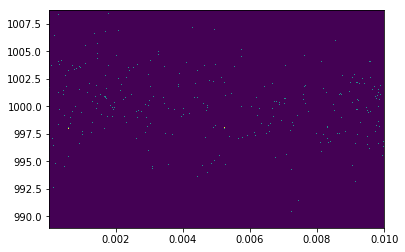

In [149]:
h = plt.hist2d(list1, list2, bins = [500, 500])

# Experiment on sampling from posterior

In [207]:
eta_list = [0.0001, 0.0005, 0.001]
k_list = [1, 100, 500]

for i in range(3):
    eta = eta_list[i]
    k = k_list[i]
    
    def energy(x):
        
sampler = IsotropicHmcSampler(unit_gaussian_energy, energy_grad=None, prng=None,
                 mom_resample_coeff=1., dtype=np.float64)

In [2]:
def gaussian(x, mu, sig):
    #return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))
    return 1./(np.sqrt(2.*np.pi)*sig)*np.exp(-np.power((x - mu), 2.)/(2 * np.power(sig, 2.))) 

In [3]:
def gaussian_energy(x, mu, sig):
    gaus = gaussian(x, mu, sig)
    return -np.log(gaus)


In [4]:
def unit_gaussian_energy(x, cache):
    gaus = gaussian(x, 3, 0.9)
    return -np.log(gaus)

In [5]:
gaussian_energy(0,0,1)

0.91893853320467267

In [6]:
sampler = IsotropicHmcSampler(unit_gaussian_energy, energy_grad=None, prng=None,
                 mom_resample_coeff=1., dtype=np.float64)

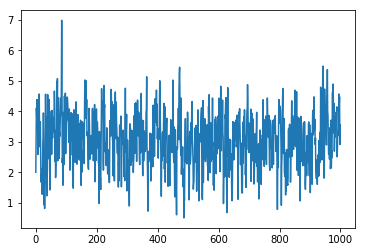

In [7]:
pos_samples, mom_samples, ratio = sampler.get_samples(np.array([2]), 0.1, 10, 1000, np.array([1]))
pos = pos_samples.ravel()
plt.plot(pos)

(array([   2.,    5.,   11.,   15.,   22.,   36.,   36.,   69.,   78.,
         101.,  107.,  104.,   90.,   85.,   63.,   56.,   49.,   23.,
          18.,   12.,    8.,    4.,    3.,    3.]),
 array([ 0.37929921,  0.61134803,  0.84339684,  1.07544565,  1.30749447,
         1.53954328,  1.7715921 ,  2.00364091,  2.23568972,  2.46773854,
         2.69978735,  2.93183616,  3.16388498,  3.39593379,  3.6279826 ,
         3.86003142,  4.09208023,  4.32412905,  4.55617786,  4.78822667,
         5.02027549,  5.2523243 ,  5.48437311,  5.71642193,  5.94847074]),
 <a list of 24 Patch objects>)

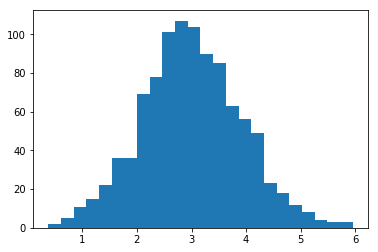

In [80]:
plt.hist(pos, bins='auto')

In [10]:
mom_samples[0][0]

0.61135382891107215

In [77]:
x = np.array([1])
x.shape[0]

1